# da

In [1]:
# !kaggle datasets download -d shinoda18/masked-crop-3ch-csv

In [2]:
# !unzip masked-crop-3ch-csv.zip

In [3]:
# !kaggle competitions download -c lyft-motion-prediction-autonomous-vehicles

In [4]:
# !kaggle datasets download -d shinoda18/hpa-3ch-croped-256

In [5]:
# !unzip hpa-3ch-croped-256.zip

In [6]:
import subprocess
import json
import pickle

DEFAULT_ATTRIBUTES = (
    'index',
    'uuid',
    'name',
    'timestamp',
    'memory.total',
    'memory.free',
    'memory.used',
    'utilization.gpu',
    'utilization.memory'
)

def get_gpu_info(nvidia_smi_path='nvidia-smi', keys=DEFAULT_ATTRIBUTES, no_units=True):
    nu_opt = '' if not no_units else ',nounits'
    cmd = '%s --query-gpu=%s --format=csv,noheader%s' % (nvidia_smi_path, ','.join(keys), nu_opt)
    output = subprocess.check_output(cmd, shell=True)
    lines = output.decode().split('\n')
    lines = [ line.strip() for line in lines if line.strip() != '' ]

    return [ { k: v for k, v in zip(keys, line.split(', ')) } for line in lines ]


import pprint
pprint.pprint(get_gpu_info())

[{'index': '0',
  'memory.free': '4781',
  'memory.total': '16160',
  'memory.used': '11379',
  'name': 'Tesla V100-SXM2-16GB',
  'timestamp': '2021/05/08 07:01:30.053',
  'utilization.gpu': '67',
  'utilization.memory': '39',
  'uuid': 'GPU-5271dac4-fa67-8890-3e2c-2d9a60803d6f'}]


In [7]:
# Try and get keras plot to work
!pip install -q pydot
!pip install -q pydotplus
!apt-get install -q graphviz

print("\n... OTHER IMPORTS STARTING ...\n")
print("\n\tVERSION INFORMATION")

# Machine Learning and Data Science Imports
# import tensorflow_addons as tfa; print(f"\t\t– TENSORFLOW ADDONS VERSION: {tfa.__version__}");
# import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None;
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import scipy; print(f"\t\t– SCIPY VERSION: {scipy.__version__}");

# Built In Imports
from collections import Counter
from datetime import datetime
import multiprocessing
from glob import glob
import warnings
import requests
# import imageio
import IPython
import urllib
import zipfile
import pickle
import random
import shutil
import string
import math
import tqdm
import time
import gzip
import io
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
# import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
# import plotly
import PIL
import cv2
import ast



E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?

... OTHER IMPORTS STARTING ...


	VERSION INFORMATION
		– NUMPY VERSION: 1.19.5
		– SCIPY VERSION: 1.6.2
		– MATPLOTLIB VERSION: 3.4.1


In [8]:
# !pip install -q transformers
# !pip -q install timm
# !pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
# !pip -q install albumentations==0.5.2

In [9]:
# !pip install librosa
# !sudo apt-get install libsndfile1

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
# from warmup_scheduler import GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr

import os, glob, random, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display
import soundfile as sf
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from typing import Optional, List

from tqdm import tqdm
from functools import partial
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn import metrics


from transformers import get_linear_schedule_with_warmup

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout,OpticalDistortion,GridDistortion
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
from torch.utils.data import DataLoader, Dataset

from torch.optim import Adam, SGD
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score
# from torchlibrosa.stft import Spectrogram, LogmelFilterBank
# from torchlibrosa.augmentation import SpecAugmentation

# from catalyst.dl import SupervisedRunner, State, CallbackOrder, Callback, CheckpointCallback

import timm
# from timm.models.efficientnet import tf_efficientnet_b0_ns

import torchvision.models as models
import pathlib

import time
from contextlib import contextmanager
import math
# from adabelief_pytorch import AdaBelief

# HELPER FUNCTIONS

In [11]:
def load_image_scaled(img_id, img_dir, img_size=512, load_style="tf"):
    """ Load An Image Using ID and Directory Path - Composes 4 Individual Images """
    def __load_with_tf(path, img_size=512):
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=1)
        return tf.image.resize(img, (img_size, img_size))[..., 0]
    
    def __load_with_pil(path, img_size=512):
        img = Image.open(path)
        img = img.resize((img_size, img_size))
        return np.asarray(img)
    
    def __load_with_cv2(path, img_size=512):
        img = cv2.imread(path, 0)
        img = cv2.resize(img, (img_size, img_size))
        return img
        
    if load_style is "tf":
        load_fn = __load_with_tf
    elif load_style is "PIL":
        load_fn = __load_with_pil
    else:
        load_fn = __load_with_cv2
    
    return np.stack(
        [np.asarray(load_fn(os.path.join(img_dir, img_id+f"_{c}.png"), img_size)/255.) for c in ["red", "yellow", "blue"]], axis=2
    )





def decode_img(img, img_size=(224,224)):
    """TBD"""
    
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=1)

    # resize the image to the desired size
    return tf.cast(tf.image.resize(img, img_size), tf.uint8)

#=================================================
# image loader, using rgb only here
def load_RGBY_image(image_id, train_or_test='train', image_size=None):
    red = read_img(image_id, "red", train_or_test, image_size)
    green = read_img(image_id, "green", train_or_test, image_size)
    blue = read_img(image_id, "blue", train_or_test, image_size)
    #yellow = read_img(image_id, "yellow", train_or_test, image_size)
    stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
    return stacked_images

# 
def read_img(image_id, color, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.max() > 255:
        img_max = img.max()
        img = (img/255).astype('uint8')
    return img

# make annotation helper called multi processes
def mk_ann(idx):
    image_id = df.iloc[idx].ID
    class_id = df.iloc[idx].Label
    anno = mk_mmdet_custom_data(image_id, class_id)
    img = load_RGBY_image(image_id, train_or_test)
    cv2.imwrite(f'{img_dir}/{image_id}.jpg', img)
    return anno, idx, image_id
#=================================================



def get_color_path_maps(color_dirs, tp_id_map):
    c_p_maps = [{k:[] for k in INT_2_STR.keys()} for _ in range(len(color_dirs))]
    color_d_paths = [
        [d_path for d_path in os.listdir(color_dir) if d_path.endswith("_256")] \
        for color_dir in color_dirs
    ]
    for c in tqdm(color_d_paths[0], total=len(color_d_paths[0])):
        
        # Get class stuff
        cls = c.split("_", 1)[1].rsplit("_",1)[0]
        cls_idx = STR_2_INT_LOWER[cls]
        
        # Get the relevant color directories
        c_dirs = [
            os.path.join(color_dir, c.replace("red", clr), "data", "train_tiles", cls) \
            for clr, color_dir in zip(["red", "green", "blue", "yellow"], color_dirs)
        ]

        # Update map
        for f_name in tqdm(os.listdir(c_dirs[0]), total=len(os.listdir(c_dirs[0]))):
            # get the relevant full paths
            full_paths = [os.path.join(c_dir, f_name.replace("red", clr)) for clr, c_dir in zip(["red", "green", "blue", "yellow"], c_dirs)]
            if tp_id_map==None:
                for c_p_map, full_path in zip(c_p_maps, full_paths):
                    c_p_map[cls_idx].append(full_path)
            elif (f_name.endswith(".png") and ("negative" in full_paths[0] or f_name.rsplit("_", 1)[0] in tp_id_map[cls_idx])):
                for c_p_map, full_path in zip(c_p_maps, full_paths):
                    c_p_map[cls_idx].append(full_path)
            else:
                for c_p_map, full_path in zip(c_p_maps, full_paths):
                    c_p_map[STR_2_INT["Negative"]].append(full_path)
    return [{k:sorted(v) for k,v in c_p_map.items()} for c_p_map in c_p_maps]




def get_tp_id_map(pkl_dir):
    """ TBD """
    # Capture all relevant paths
    pkl_paths = [
        os.path.join(pkl_dir, f_name) \
        for f_name in os.listdir(pkl_dir) \
        if f_name.endswith(".pkl")
    ]
    
    # REMOVE AFTER UPDATING CLASSBASED NOTEBOOK
    pkl_paths.append("/kaggle/input/tmp-intermediate-filaments-pkl-file/intermediate_filaments_tp_list.pkl")
    
    # Initialize
    tp_id_map = {}
    for path in pkl_paths:
        class_id = STR_2_INT_LOWER[path.rsplit("/", 1)[1].replace("_tp_list.pkl", "")]
        with open(path, "rb") as f:
            tp_id_map[class_id] = pickle.load(f)
    return tp_id_map

    
def plot_rgb(arr, figsize=(12,12)):
    """ Plot 3 Channel Microscopy Image """
    plt.figure(figsize=figsize)
    plt.title(f"RGB Composite Image", fontweight="bold")
    plt.imshow(arr)
    plt.axis(False)
    plt.show()    

    
def convert_rgby_to_rgb(arr):
    """ Convert a 4 channel (RGBY) image to a 3 channel RGB image.
    
    Advice From Competition Host/User: lnhtrang

    For annotation (by experts) and for the model, I guess we agree that individual 
    channels with full range px values are better. 
    In annotation, we toggled the channels. 
    For visualization purpose only, you can try blending the channels. 
    For example, 
        - red = red + yellow
        - green = green + yellow/2
        - blue=blue.
        
    Args:
        arr (numpy array): The RGBY, 4 channel numpy array for a given image
    
    Returns:
        RGB Image
    """
    
    rgb_arr = np.zeros_like(arr[..., :-1])
    rgb_arr[..., 0] = arr[..., 0]
    rgb_arr[..., 1] = arr[..., 1]+arr[..., 3]/2
    rgb_arr[..., 2] = arr[..., 2]
    
    return rgb_arr
    
    
def plot_ex(arr, figsize=(20,6), title=None, plot_merged=True, rgb_only=False):
    """ Plot 4 Channels Side by Side """
    if plot_merged and not rgb_only:
        n_images=5 
    elif plot_merged and rgb_only:
        n_images=4
    elif not plot_merged and rgb_only:
        n_images=4
    else:
        n_images=3
    plt.figure(figsize=figsize)
    if type(title) == str:
        plt.suptitle(title, fontsize=20, fontweight="bold")

    for i, c in enumerate(["Red Channel – Microtubles", "Green Channel – Protein of Interest", "Blue - Nucleus", "Yellow – Endoplasmic Reticulum"]):
        if not rgb_only:
            ch_arr = np.zeros_like(arr[..., :-1])        
        else:
            ch_arr = np.zeros_like(arr)
        if c in ["Red Channel – Microtubles", "Green Channel – Protein of Interest", "Blue - Nucleus"]:
            ch_arr[..., i] = arr[..., i]
        else:
            if rgb_only:
                continue
            ch_arr[..., 0] = arr[..., i]
            ch_arr[..., 1] = arr[..., i]
        plt.subplot(1,n_images,i+1)
        plt.title(f"{c.title()}", fontweight="bold")
        plt.imshow(ch_arr)
        plt.axis(False)
        
    if plot_merged:
        plt.subplot(1,n_images,n_images)
        
        if rgb_only:
            plt.title(f"Merged RGB", fontweight="bold")
            plt.imshow(arr)
        else:
            plt.title(f"Merged RGBY into RGB", fontweight="bold")
            plt.imshow(convert_rgby_to_rgb(arr))
        plt.axis(False)
        
    plt.tight_layout(rect=[0, 0.2, 1, 0.97])
    plt.show()
    
    
def flatten_list_of_lists(l_o_l):
    return [item for sublist in l_o_l for item in sublist]


def create_input_list(crp, cgp, cbp, cyp, shuffle=True, val_split=0.025):
    lbl_arr = flatten_list_of_lists([[k,]*len(v) for k, v in sorted(crp.items())])
    cr_arr = flatten_list_of_lists([v for k,v in sorted(crp.items())])
    cg_arr = flatten_list_of_lists([v for k,v in sorted(cgp.items())])
    cb_arr = flatten_list_of_lists([v for k,v in sorted(cbp.items())])
    cy_arr = flatten_list_of_lists([v for k,v in sorted(cyp.items())])
    
    if val_split is not None:
        val_lbl_arr = lbl_arr[:int(len(lbl_arr)*val_split)]
        lbl_arr = lbl_arr[int(len(lbl_arr)*val_split):]
        
        val_cr_arr = cr_arr[:int(len(cr_arr)*val_split)]
        cr_arr = cr_arr[int(len(cr_arr)*val_split):]
        
        val_cg_arr = cg_arr[:int(len(cg_arr)*val_split)]
        cg_arr = cg_arr[int(len(cg_arr)*val_split):]
        
        val_cb_arr = cb_arr[:int(len(cb_arr)*val_split)]
        cb_arr = cb_arr[int(len(cb_arr)*val_split):]

        val_cy_arr = cy_arr[:int(len(cy_arr)*val_split)]
        cy_arr = cy_arr[int(len(cy_arr)*val_split):]
        
    if shuffle:
        to_shuffle = list(zip(cr_arr, cg_arr, cb_arr, cy_arr, lbl_arr))
        random.shuffle(to_shuffle)
        cr_arr, cg_arr, cb_arr, cy_arr, lbl_arr = zip(*to_shuffle)
        
        if val_split is not None:
            val_to_shuffle = list(zip(val_cr_arr, val_cg_arr, val_cb_arr, val_cy_arr, val_lbl_arr))
            random.shuffle(val_to_shuffle)
            val_cr_arr, val_cg_arr, val_cb_arr, val_cy_arr, val_lbl_arr = zip(*val_to_shuffle)
    
    if val_split is None:
        return list(cr_arr), list(cg_arr), list(cb_arr), list(cy_arr), list(lbl_arr)
    else:
        return (list(cr_arr), list(cg_arr), list(cb_arr), list(cy_arr), list(lbl_arr)), \
               (list(val_cr_arr), list(val_cg_arr), list(val_cb_arr), list(val_cy_arr), list(val_lbl_arr))


def get_class_wts(single_ch_paths, n_classes=19, exclude_mitotic=True, multiplier=10, return_counts=False):
    """ TBD """
    # Get class counts
    class_counts = {c_idx:len(single_ch_paths[c_idx]) for c_idx in range(n_classes)}

    # Exclude mitotic spindle
    if exclude_mitotic:
        real_min_count = list(sorted(class_counts.values(), reverse=True))[-2]
    else:
        real_min_count = list(sorted(class_counts.values(), reverse=True))[-1]

    # Calculate weights
    class_wts = {k:min(1, multiplier*(real_min_count/v)) for k,v in class_counts.items()}

    if exclude_mitotic:
        # Manually adjust mitotic spindle to a more appropriate value
        class_wts[min(class_counts, key=class_counts.get)] = 1.0

    if return_counts:
        return class_wts, class_counts
    else:
        return class_wts

In [12]:
def rle_to_mask(rle_string, height, width):
    """ Convert RLE sttring into a binary mask 
    
    Args:
        rle_string (rle_string): Run length encoding containing 
            segmentation mask information
        height (int): Height of the original image the map comes from
        width (int): Width of the original image the map comes from
    
    Returns:
        Numpy array of the binary segmentation mask for a given cell
    """
    rows,cols = height,width
    rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rle_pairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

In [13]:
def read_img(image_path,image_size=256):
#     filename = f'{ROOT}/{train_or_test}/{image_id}_{color}.png'
#     assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
#     if image_size is not None:
#         img = cv2.resize(img, (image_size, image_size))
    if img.max() > 255:
        img_max = img.max()
        print('==============img_max')
        img = (img/255).astype('uint8')
    return img

In [14]:
def concat_label(cels_ids):
    cels_ids = str(cels_ids)
    cels_ids = eval(cels_ids)
    len_cels_ids = len(cels_ids)
    len_cels_ids_list = []
    for x in range(len_cels_ids):
        len_cels_ids_list.append(cels_ids[x].split(','))
#     print(len_cels_ids_list)
        
#     cels_ids = cels_ids.split(',')#cels_ids[0].split(',')
    labels = np.zeros(19, dtype="f")
    labels = []
    for i in len_cels_ids_list:
        i = i[0]
        i = int(i)
        labels.append(i)
#         labels[i] = 1
    return labels
        
        

In [16]:
def set_label(labe): 
    return list(set(labe)) 

In [20]:
def how_len(yum):
    if len(yum) > 1:
        return 1
    else:
        return 0 

In [29]:
# import numpy as np
# from sklearn.model_selection import GroupKFold
# #make group k_fold
# id_list = train_single_and_multi_df.common_ID.value_counts().index

# FOLDS = 5
# for k in range(len(id_list)):
#     train_single_and_multi_df.loc[train_single_and_multi_df.common_ID==id_list[k],'fold'] = k%FOLDS

# load csv

In [18]:
# only_multi_train_df = pd.read_csv('only_multi_train_df.csv')#これをhandで修正中！！！
train_df_not_pub = pd.read_csv('train_df_not_pub.csv')#これをhandで修正中！！！


In [19]:
train_df_not_pub

,common_ID,saved_label
0,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[0, 1, 2, 7]"
1,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,"[16, 2]"
2,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,"[0, 2]"
3,0032a07e-bba9-11e8-b2ba-ac1f6b6435d0,"[0, 15]"
4,0038d6a6-bb9a-11e8-b2b9-ac1f6b6435d0,"[16, 0]"
...,...,...
11282,ffd298f4-bbc7-11e8-b2bc-ac1f6b6435d0,"[16, 0, 4]"
11283,ffd2b880-bba8-11e8-b2ba-ac1f6b6435d0,"[16, 0, 3]"
11284,ffe55eba-bbba-11e8-b2ba-ac1f6b6435d0,"[0, 5]"
11285,ffe61798-bbc3-11e8-b2bc-ac1f6b6435d0,"[12, 14, 7]"


In [20]:
train_df_pub = pd.read_csv('train_df_pub.csv')

In [21]:
train_df_pub

,common_ID,saved_label
0,1231_G1_1,"[0, 13]"
1,264_A10_2,"[2, 13, 16]"
2,198_F5_1,"[0, 16]"
3,488_C4_1,"[0, 13]"
4,733_F7_1,"[0, 1]"
...,...,...
22628,412_A3_3,"[4, 16]"
22629,614_A12_1,"[0, 16]"
22630,125_C12_1,"[0, 16]"
22631,1308_C8_3,"[0, 16]"


In [22]:
def make_saved_path_not_pub(df):
    return 'train/' + df

In [25]:
train_df_not_pub['saved_path'] = train_df_not_pub.common_ID.map(make_saved_path_not_pub)

In [26]:
train_df_not_pub

,common_ID,saved_label,saved_path
0,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[0, 1, 2, 7]",train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
1,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,"[16, 2]",train/0020af02-bbba-11e8-b2ba-ac1f6b6435d0
2,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,"[0, 2]",train/00285ce4-bba0-11e8-b2b9-ac1f6b6435d0
3,0032a07e-bba9-11e8-b2ba-ac1f6b6435d0,"[0, 15]",train/0032a07e-bba9-11e8-b2ba-ac1f6b6435d0
4,0038d6a6-bb9a-11e8-b2b9-ac1f6b6435d0,"[16, 0]",train/0038d6a6-bb9a-11e8-b2b9-ac1f6b6435d0
...,...,...,...
11282,ffd298f4-bbc7-11e8-b2bc-ac1f6b6435d0,"[16, 0, 4]",train/ffd298f4-bbc7-11e8-b2bc-ac1f6b6435d0
11283,ffd2b880-bba8-11e8-b2ba-ac1f6b6435d0,"[16, 0, 3]",train/ffd2b880-bba8-11e8-b2ba-ac1f6b6435d0
11284,ffe55eba-bbba-11e8-b2ba-ac1f6b6435d0,"[0, 5]",train/ffe55eba-bbba-11e8-b2ba-ac1f6b6435d0
11285,ffe61798-bbc3-11e8-b2bc-ac1f6b6435d0,"[12, 14, 7]",train/ffe61798-bbc3-11e8-b2bc-ac1f6b6435d0


In [27]:
def make_saved_path_pub(df):
    return 'publichpa_1024/' + df

In [28]:
train_df_pub['saved_path'] = train_df_pub.common_ID.map(make_saved_path_pub)

In [29]:
train_df_pub

,common_ID,saved_label,saved_path
0,1231_G1_1,"[0, 13]",publichpa_1024/1231_G1_1
1,264_A10_2,"[2, 13, 16]",publichpa_1024/264_A10_2
2,198_F5_1,"[0, 16]",publichpa_1024/198_F5_1
3,488_C4_1,"[0, 13]",publichpa_1024/488_C4_1
4,733_F7_1,"[0, 1]",publichpa_1024/733_F7_1
...,...,...,...
22628,412_A3_3,"[4, 16]",publichpa_1024/412_A3_3
22629,614_A12_1,"[0, 16]",publichpa_1024/614_A12_1
22630,125_C12_1,"[0, 16]",publichpa_1024/125_C12_1
22631,1308_C8_3,"[0, 16]",publichpa_1024/1308_C8_3


In [32]:
train_all_df = pd.concat([train_df_pub,train_df_not_pub]).reset_index(drop=True)

In [33]:
train_all_df

,common_ID,saved_label,saved_path
0,1231_G1_1,"[0, 13]",publichpa_1024/1231_G1_1
1,264_A10_2,"[2, 13, 16]",publichpa_1024/264_A10_2
2,198_F5_1,"[0, 16]",publichpa_1024/198_F5_1
3,488_C4_1,"[0, 13]",publichpa_1024/488_C4_1
4,733_F7_1,"[0, 1]",publichpa_1024/733_F7_1
...,...,...,...
33915,ffd298f4-bbc7-11e8-b2bc-ac1f6b6435d0,"[16, 0, 4]",train/ffd298f4-bbc7-11e8-b2bc-ac1f6b6435d0
33916,ffd2b880-bba8-11e8-b2ba-ac1f6b6435d0,"[16, 0, 3]",train/ffd2b880-bba8-11e8-b2ba-ac1f6b6435d0
33917,ffe55eba-bbba-11e8-b2ba-ac1f6b6435d0,"[0, 5]",train/ffe55eba-bbba-11e8-b2ba-ac1f6b6435d0
33918,ffe61798-bbc3-11e8-b2bc-ac1f6b6435d0,"[12, 14, 7]",train/ffe61798-bbc3-11e8-b2bc-ac1f6b6435d0


In [34]:
#step1
# train_all_df = pd.read_csv('train_df_group_kfold.csv',dtype={"saved_ID": 'object', "saved_label": "object","saved_path": 'object', "common_ID": "object","fold": "int64"})

In [35]:
# #step2
# train_all_df = pd.read_csv('step1_peseudo_df_relabeled.csv')
# train_all_df['saved_label'] = train_all_df['saved_label'].astype(str)

# #drop100
# train_all_df = train_all_df[train_all_df['saved_label']!='100'].reset_index(drop=True)

In [36]:
# def split_label(df):
#     df = df.split(',')
#     return df

In [37]:
# train_all_df['saved_label'] = train_all_df['saved_label'].map(split_label)

In [38]:
# train_all_df['saved_label'].value_counts()

In [43]:
# train_all_df[train_all_df['saved_label'].apply(find_label)]

In [44]:
# # load multi
# step2_multi_masked_crop_bgr_256_df = pd.read_csv('step2_multi_masked_crop_bgr_256_df.csv')

In [45]:
# #drop 11 重複している為
# masked_crop_bgr_256_df_in_label11 = pd.read_csv('masked_crop_bgr_256_df_in_label11.csv')

In [46]:
# merged_df = pd.merge(step2_multi_masked_crop_bgr_256_df,masked_crop_bgr_256_df_in_label11,on='saved_ID',how='left')
# merged_df = merged_df.fillna(0)
# step2_multi_masked_crop_bgr_256_df = merged_df[merged_df['saved_label_y']==0].reset_index(drop=True)
# step2_multi_masked_crop_bgr_256_df = step2_multi_masked_crop_bgr_256_df.iloc[:,:3]
# step2_multi_masked_crop_bgr_256_df = step2_multi_masked_crop_bgr_256_df.rename(columns={'saved_label_x':'saved_label','saved_path_x':'saved_path'}
# step2_multi_masked_crop_bgr_256_df.to_csv('step2_multi_masked_crop_bgr_256_df_fortrain.csv',index=False))

In [47]:
# step2_multi_masked_crop_bgr_256_df = pd.read_csv('step2_multi_masked_crop_bgr_256_df_fortrain.csv')

In [48]:
# step2_multi_masked_crop_bgr_256_df['saved_label'] = step2_multi_masked_crop_bgr_256_df['saved_label'].map(split_label)

In [49]:
# step2_multi_masked_crop_bgr_256_df

In [50]:
# train_all_df = pd.concat([train_all_df,step2_multi_masked_crop_bgr_256_df])

In [51]:
def split_str(df):
    common_path = df.split('_')[0]
    return common_path

In [52]:
# train_all_df['common_ID'] = train_all_df.saved_ID.map(split_str)

In [53]:
# import numpy as np
# from sklearn.model_selection import GroupKFold
# #make group k_fold
# id_list = train_all_df.common_ID.value_counts().index

# FOLDS = 5
# for k in range(len(id_list)):
#     train_all_df.loc[train_all_df.common_ID==id_list[k],'fold'] = k%FOLDS

In [54]:
# train_all_df[train_all_df['fold']==0]

In [55]:
# train_all_df

In [56]:
# train_all_df.to_csv('multi_train_all_df_fold.csv',index=False)

In [57]:
# pd.read_csv('multi_train_all_df_fold.csv')

In [53]:
# # #clean label
# mluti_oof = pd.read_csv('OUTPUT/exp16_hpa_pred_multi_label_effnet5_relabeled/all_fold_oof_df.csv')

In [54]:
# mluti_oof

In [55]:
# mluti_oof = pd.concat([step2_multi_masked_crop_bgr_256_df,mluti_oof],axis=1)

In [56]:
# mluti_oof['saved_label'].apply(sorted)

In [57]:
def find_label(label):
    return ('0' in label and '1' in label and  '2' in label)
    

In [58]:
def find_label(label):
    return ('0' in label and '1' in label and  '3' in label)

In [59]:
# mluti_oof[mluti_oof['saved_label'].map(find_label)]

In [60]:
# for xx in range(19):
#     def find_label(label):
#         return ('6' in label and f'{xx}' in label)
#     print(f'6_{xx}/',len(mluti_oof[mluti_oof['saved_label'].map(find_label)]))
#     print('======')

In [61]:
# for zz in range(0,6,1):
#     for xx in range(1,6,1):
#         for yy in range(2,6,1):
#             def find_label(label):
#                 return (f'{zz}' in label and f'{xx}' in label and f'{yy}' in label)

#             print(f'{zz}_{xx}_{yy}/',len(mluti_oof[mluti_oof['saved_label'].map(find_label)]))
#             print('======')

In [62]:
#5_1_2/ 44
#0_5_4/ 107
#0_5_3/ 131
#0_5_2/ 506
#0_3_2/ 125
#0_1_5/ 229
#0_1_3/ 209
#0_1_2/ 1043

In [63]:
# common_list = []
# for ff in range(19):
# #     ff = 16
#     for xx in range(19):
#         def find_label(label):
#             return (f'{ff}' in label and f'{xx}' in label)
#         print(f'{ff}_{xx}/',len(mluti_oof[mluti_oof['saved_label'].map(find_label)]))
#         print('======')
#         now_list = [ff,xx]
#         if len(mluti_oof[mluti_oof['saved_label'].map(find_label)]) == 0:
#             common_list.append(now_list)

In [64]:
##################################eda######################################
#1_15/ 0

#6_8/ 0
#6_15/ 0

#9_15/ 0

#10_15/ 0

#15_17/ 0

In [65]:
#後処理でやる価値あるかも？
##################################eda######################################
#0_1_4/ 0
#0_2_4/ 0
#0_3_4/ 0

#1_2_3/ 0
#1_2_4/ 0
#1_3_4/ 0
#1_3_5/ 0
#1_4_5/ 0

#2_3_4/ 0
#2_3_5/ 0
#2_5_4/ 0

In [66]:
# mluti_oof[mluti_oof['saved_label'].apply(lambda x: '5' in x)]

In [67]:
# #0は残す！！ 149162もあるから
# #0~5は残す！！　シングルラベルではラベルづけしなかったから

# for index, row in enumerate(mluti_oof.values):
#     if '17' in row[1]:
#         print(row[0])
#         print(row[1])
#         pred_confs = row[3:]
#         print(np.sort(pred_confs)[::-1])
#         print('')
#         print(np.argsort(pred_confs)[::-1])
#         print('===========')
#     if index == 10000:
#         break

In [68]:
# #0は残す！！ 149162もあるから
# #0~5は残す！！　シングルラベルではラベルづけしなかったから
# row_list = []
# for index, row in enumerate(mluti_oof.values):
# #     if '12' in row[1]:


#     pred_confs = row[3:]

#     if np.sort(pred_confs)[::-1][0] > 0.5:
# #         print(row[0])
# #             print(row[1])
# #             print(np.argsort(pred_confs)[::-1][0])
#         if str(np.argsort(pred_confs)[::-1][0]) not in row[1]:
# #             print(row[1])
# #             print(np.sort(pred_confs)[::-1])
# #             print('')
# #             print(np.argsort(pred_confs)[::-1])

#             if str(np.argsort(pred_confs)[::-1][0]) == '11':
# #                 print('||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||')
# #                 print(np.sort(pred_confs)[::-1])
# #                 print(row[0])
# #                 print(row[1])
#                 row[1] = ['11']
#                 print(row[1])
#             elif str(np.argsort(pred_confs)[::-1][0]) == '18':
# #                 print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
# #                 print(np.sort(pred_confs)[::-1])
# #                 print(row[0])
# #                 print(row[1])
#                 row[1] = ['18']
#                 print(row[1])
#             else:
#                 if np.sort(pred_confs)[::-1][0] > 0.7:
#                     print(row[1])
#                     row[1].append(str(np.argsort(pred_confs)[::-1][0]))#1st_confをlabelに加える
#                     print('after',row[1])
#     row_list.append(row)
                    
            
        
# #         print('===========')
# #     if index == 200000:
# #         break
# train_df = pd.DataFrame(row_list,columns=mluti_oof.columns.to_list())

In [69]:
# train_df[train_df['saved_label'].apply(lambda x: '18' in x)]

In [70]:
# train_df = train_df.iloc[:,:3]

In [71]:
# train_df['common_ID'] = train_df.saved_ID.map(split_str)

In [72]:
# import numpy as np
# from sklearn.model_selection import GroupKFold
# #make group k_fold
# id_list = train_df.common_ID.value_counts().index

# FOLDS = 5
# for k in range(len(id_list)):
#     train_df.loc[train_df.common_ID==id_list[k],'fold'] = k%FOLDS

In [73]:
# train_df.to_csv('only_multi_train_df.csv',index=False)

In [74]:
# only_multi_train_df = pd.read_csv('only_multi_train_df.csv')

In [75]:
# only_multi_train_df

In [76]:
# #single=>multiにしたい　predする
# train_all_df

In [77]:
# #check fold
# species_id_count = []
# for saved_label_list in train_all_df[train_all_df['fold']==4]['saved_label']:
#     saved_label_list = saved_label_list[0].split(',')
    
#     for x in saved_label_list:
#         species_id = int(x)
#         species_id_count.append(np.array(species_id))

In [78]:
#fold0
# 16    19467
# 0      8825
# 14     7710
# 7      7249
# 12     7181
# 13     5667
# 2      5625
# 5      5618
# 4      3663
# 3      3503
# 1      3103
# 8      3067
# 9      2775
# 10     2401
# 6      2222
# 17     1962
# 15     1336
# 18      745
# 11      278
# dtype: int64

#fold1
# 16    19254
# 0      8884
# 12     7833
# 14     7554
# 7      7092
# 5      5460
# 13     5242
# 2      5205
# 4      4238
# 3      3582
# 8      2959
# 1      2924
# 10     2646
# 9      2629
# 6      2458
# 17     2001
# 15     1323
# 18     1044
# 11      230
# dtype: int64




In [79]:
# #labelが正しいとして
# train_all_df_drop = []
# drop_idx = []
# for idx,rows in enumerate (train_all_df.values):
    
#     target = rows[1]
#     target = target.split(',')
#     for label in target:
#         label = int(label)
#         if label == 11:
#             continue
#         if rows[label+5] <0.6:
#             drop_idx.append(idx)
            
# #     if idx == 50:
# #         break
    
    
    

In [80]:
# len(drop_idx)

In [81]:
# len(set(drop_idx))

In [82]:
# drop_idx_drop_duplicates = set(drop_idx)

In [83]:
# train_all_df = train_all_df.drop(index=drop_idx_drop_duplicates).reset_index(drop=True)

In [84]:
# train_all_df

In [85]:
# train_all_df[train_all_df['fold']!=0].saved_label.value_counts().head(50)

# utils

In [18]:
# Fix Warmup Bug

from warmup_scheduler import GradualWarmupScheduler  


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Aug

In [82]:
# # ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
#             ToGray(),
#             Resize(CFG.size, CFG.size),
            RandomResizedCrop(256, 256, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            RandomBrightnessContrast(p=0.1, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1)),
            HueSaturationValue(p=0.1, hue_shift_limit=0.1, sat_shift_limit=0.1, val_shift_limit=0.1),
            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=5, border_mode=cv2.BORDER_CONSTANT, p=0.8),
            Cutout(p=0.5, max_h_size=16, max_w_size=16, fill_value=(0.), num_holes=50),
            Normalize(mean = (0.0680, 0.0583, 0.0566), std = (0.1464, 0.1249, 0.1612)
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
#             Resize(CFG.size, CFG.size),
            Normalize(mean = (0.0680, 0.0583, 0.0566), std = (0.1464, 0.1249, 0.1612)
            ),
            ToTensorV2(),

        ])
#mean=(0.0513, 0.0298, 0.0519), std=(0.1213, 0.0851, 0.1480)


# mean = (0.0680, 0.0583, 0.0566), std = (0.1464, 0.1249, 0.1612)


In [42]:
# # # ====================================================
# # Transforms hard
# # ====================================================
# def get_transforms(*, data):
    
#     if data == 'train':
#         return Compose([
# #             ToGray(),
#             # Resize(CFG.size, CFG.size),
#             RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
#             Transpose(p=0.5),
#             HorizontalFlip(p=0.5),
#             VerticalFlip(p=0.5),
#             # RandomBrightnessContrast(p=0.5, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1)),
#             # HueSaturationValue(hue_shift_limit=40, sat_shift_limit=40, val_shift_limit=0, p=0.75),
#             # ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=30, border_mode=0, p=0.75),
#             # OneOf([
#             #           OpticalDistortion(distort_limit=1.),
#             #           GridDistortion(num_steps=5, distort_limit=1.),
#             #       ], p=0.7),
#             # Cutout(max_h_size=int(CFG.size * 0.375), max_w_size=int(CFG.size * 0.375), num_holes=1, p=0.7), 
#             Normalize(
#             ),
#             ToTensorV2(),
#         ])

#     elif data == 'valid':
#         return Compose([
#             Resize(CFG.size, CFG.size),
#             Normalize(
#             ),
#             ToTensorV2(),

#         ])

# MODEL

In [43]:
# sigmoid = torch.nn.Sigmoid()

# class Swish(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, i):
#         result = i * sigmoid(i)
#         ctx.save_for_backward(i)
#         return result
#     @staticmethod
#     def backward(ctx, grad_output):
#         i = ctx.saved_variables[0]
#         sigmoid_i = sigmoid(i)
#         return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
# swish = Swish.apply

# class Swish_module(nn.Module):
#     def forward(self, x):
#         return swish(x)
# swish_layer = Swish_module()



# class Efficientnet_b5(nn.Module):
#     def __init__ (self):
#         super().__init__()
#         self.backbone = timm.create_model('tf_efficientnet_b5_ns', pretrained=True)
#         in_ch = self.backbone.classifier.in_features
# #         self.backbone.classifier = nn.Linear(2048, 19)#<==========================
#         self.backbone.meta = nn.Sequential(
#                 nn.Linear(in_ch, 512),
#                 nn.BatchNorm1d(512),
#                 Swish_module(),
#                 nn.Dropout(p=0.5),
#                 nn.Linear(512, 128),
#                 nn.BatchNorm1d(128),
#                 Swish_module(),
#                 nn.Dropout(p=0.25),
#             )
#         self.backbone.classifier =  nn.Identity()
#         self.myfc = nn.Linear(128, 19)
        
#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.backbone.meta(x)
#         x = self.myfc(x)
#         return x

In [44]:
# sigmoid = torch.nn.Sigmoid()

# class Swish(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, i):
#         result = i * sigmoid(i)
#         ctx.save_for_backward(i)
#         return result
#     @staticmethod
#     def backward(ctx, grad_output):
#         i = ctx.saved_variables[0]
#         sigmoid_i = sigmoid(i)
#         return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
# swish = Swish.apply

# class Swish_module(nn.Module):
#     def forward(self, x):
#         return swish(x)
# swish_layer = Swish_module()



# class Efficientnet_b7(nn.Module):
#     def __init__ (self):
#         super().__init__()
#         self.backbone = timm.create_model('tf_efficientnet_b7_ns', pretrained=True)
#         in_ch = self.backbone.classifier.in_features
# #         self.backbone.classifier = nn.Linear(2048, 19)#<==========================
#         self.backbone.meta = nn.Sequential(
#                 nn.Linear(in_ch, 512),
#                 nn.BatchNorm1d(512),
#                 Swish_module(),
#                 nn.Dropout(p=0.5),
#                 nn.Linear(512, 128),
#                 nn.BatchNorm1d(128),
#                 Swish_module(),
#                 nn.Dropout(p=0.25),
#             )
#         self.backbone.classifier =  nn.Identity()
#         self.myfc = nn.Linear(128, 19)
        
#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.backbone.meta(x)
#         x = self.myfc(x)
#         return x

In [23]:
# class Efficientnet_b5(nn.Module):
#     def __init__ (self):
#         super().__init__()
#         self.backbone = timm.create_model('tf_efficientnet_b5_ns', pretrained=True)
#         in_ch = self.backbone.classifier.in_features
#         self.backbone.classifier = nn.Linear(in_ch, 19)#<==========================

        
#     def forward(self, x):
#         x = self.backbone(x)
# #         x = self.backbone.classifier(x)
#         return x

In [24]:
class Efficientnet_b7(nn.Module):
    def __init__ (self):
        super().__init__()
        self.backbone = timm.create_model('tf_efficientnet_b7_ns', pretrained=True)
        in_ch = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_ch, 19)#<==========================

        
    def forward(self, x):
        x = self.backbone(x)
#         x = self.backbone.classifier(x)
        return x

In [25]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
model = Efficientnet_b7()
    
para = get_n_params(model)/1000000
print(f'{para}M') # 14.9M (Ours) / 15M(Paper)

28.379715M


In [26]:
# imp = torch.ones(1,3,255,255)

In [27]:
# sigmoid = torch.nn.Sigmoid()

# class Swish(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, i):
#         result = i * sigmoid(i)
#         ctx.save_for_backward(i)
#         return result
#     @staticmethod
#     def backward(ctx, grad_output):
#         i = ctx.saved_variables[0]
#         sigmoid_i = sigmoid(i)
#         return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
# swish = Swish.apply

# class Swish_module(nn.Module):
#     def forward(self, x):
#         return swish(x)
# swish_layer = Swish_module()

# class enetv2(nn.Module):
#     def __init__(self, backbone, out_dim, n_meta_features=0, load_pretrained=True):

#         super(enetv2, self).__init__()
#         self.n_meta_features = n_meta_features
#         self.enet = geffnet.create_model(enet_type.replace('-', '_'), pretrained=True)
#         self.dropout = nn.Dropout(0.5)
#         in_ch = self.enet.classifier.in_features
#         if n_meta_features > 0:
#             self.meta = nn.Sequential(
#                 nn.Linear(n_meta_features, 512),
#                 nn.BatchNorm1d(512),
#                 Swish_module(),
#                 nn.Dropout(p=0.3),
#                 nn.Linear(512, 128),
#                 nn.BatchNorm1d(128),
#                 Swish_module(),
#             )
#             in_ch += 128
#         self.myfc = nn.Linear(in_ch, out_dim)
#         self.enet.classifier = nn.Identity()

#     def extract(self, x):
#         x = self.enet(x)
#         return x

#     def forward(self, x, x_meta=None):
#         x = self.extract(x).squeeze(-1).squeeze(-1)
#         if self.n_meta_features > 0:
#             x_meta = self.meta(x_meta)
#             x = torch.cat((x, x_meta), dim=1)
#             x = self.myfc(self.dropout(x))
#         return x

# LOSS

In [33]:
class FocalLoss_(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
               ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss

        return loss.sum(dim=1).mean()
    
class FbetaLoss(nn.Module):
    def __init__(self, beta=1):
        super(FbetaLoss, self).__init__()
        self.small_value = 1e-6
        self.beta = beta

    def forward(self, logits, labels):
        beta = self.beta
        batch_size = logits.size()[0]
        p = F.sigmoid(logits)
        l = labels
        num_pos = torch.sum(p, 1) + self.small_value
        num_pos_hat = torch.sum(l, 1) + self.small_value
        tp = torch.sum(l * p, 1)
        precise = tp / num_pos
        recall = tp / num_pos_hat
        fs = (1 + beta * beta) * precise * recall / (beta * beta * precise + recall + self.small_value)
        loss = fs.sum() / batch_size
        return 1 - loss

class CombineLoss(nn.Module):
    def __init__(self):
        super(CombineLoss, self).__init__()
        self.fbeta_loss = FbetaLoss(beta=2)
        self.focal_loss = FocalLoss_()
        
    def forward(self, logits, labels):
        loss_beta = self.fbeta_loss(logits, labels)
        loss_focal = self.focal_loss(logits, labels)
        return 0.5 * loss_beta + 0.5 * loss_focal

In [34]:
def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

In [35]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.device == 'GPU':
            with autocast():
                y_preds = model(images)
                
                # loss = lsep_loss_stable(y_preds, labels)
                loss = criterion(y_preds, labels)#<====================================
                # record loss
                losses.update(loss.item(), batch_size)
                if CFG.gradient_accumulation_steps > 1:
                    loss = loss / CFG.gradient_accumulation_steps
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
                if (step + 1) % CFG.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    global_step += 1

                # ############
                # if (step + 1) % 2000 == 0:
                #   scheduler.step()
                # ############
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.6f}  '
                      .format(
                       epoch, step, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(train_loader)),
                       grad_norm=grad_norm,
                       lr=scheduler.get_lr()[0],
                       ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            probs = torch.zeros((images.shape[0], 19)).to(device)#(1,19)1_cellづつだから１だが、batchでも本来可能
            if epoch < 9:
                TTA_REPEATS = 1
            else:
                TTA_REPEATS = 4
            for I in range(TTA_REPEATS):
                output = model(get_trans(images, I))
                probs += torch.sigmoid(output)
            probs /= TTA_REPEATS
            y_preds = probs
        loss = criterion(y_preds, labels)#<========================================    
        # loss = lsep_loss_stable(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      .format(
                       step, len(valid_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(valid_loader)),
                       ))
        
    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

# Dataset

In [39]:
train_all_df

,common_ID,saved_label,saved_path
0,1231_G1_1,"[0, 13]",publichpa_1024/1231_G1_1
1,264_A10_2,"[2, 13, 16]",publichpa_1024/264_A10_2
2,198_F5_1,"[0, 16]",publichpa_1024/198_F5_1
3,488_C4_1,"[0, 13]",publichpa_1024/488_C4_1
4,733_F7_1,"[0, 1]",publichpa_1024/733_F7_1
...,...,...,...
33915,ffd298f4-bbc7-11e8-b2bc-ac1f6b6435d0,"[16, 0, 4]",train/ffd298f4-bbc7-11e8-b2bc-ac1f6b6435d0
33916,ffd2b880-bba8-11e8-b2ba-ac1f6b6435d0,"[16, 0, 3]",train/ffd2b880-bba8-11e8-b2ba-ac1f6b6435d0
33917,ffe55eba-bbba-11e8-b2ba-ac1f6b6435d0,"[0, 5]",train/ffe55eba-bbba-11e8-b2ba-ac1f6b6435d0
33918,ffe61798-bbc3-11e8-b2bc-ac1f6b6435d0,"[12, 14, 7]",train/ffe61798-bbc3-11e8-b2bc-ac1f6b6435d0


In [47]:
#3色混ぜて出力
class HPADataset(data.Dataset):
    def __init__(
            self,
            df,
            transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        record = self.df.iloc[idx]
        dir_path = '/home/ubuntu/'
        path_img = record['saved_path']
   
        
#         img = cv2.imread(f'{dir_path}{path_img}.png')#BGR
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#RGB
        img = np.stack([
        cv2.imread(f'/home/ubuntu/{path_img}_red.png', 0),
        cv2.imread(f'/home/ubuntu/{path_img}_green.png', 0),
        cv2.imread(f'/home/ubuntu/{path_img}_blue.png', 0),
        ], axis=2)
        if img.max() > 255:#if uint16 
#                 print('======================!!!!',retnrn_img.max())
                img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))#uint8
        # print(img.dtype)
        # print('============',img.mean())
        # print('============',img.sum())
#         img = (img/255.0).astype(np.float32)

        # print(img.dtype)
        # print('============',img.mean())
        # print('============',img.sum())
        # print('============',img.max())
        # print('============',img.min())

        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        # print(img.dtype)
        #multi_label
        labels = np.zeros(19, dtype="f")

        cels_ids = record['saved_label']#.split(',') 
        
#         cels_ids = str(cels_ids)
#         cels_ids = eval(cels_ids)

#         cels_ids = cels_ids[0].split(',')
        # print(cels_ids)
        for i in cels_ids:
            i = int(i)
            labels[i] = 1

        # img = img.float()
        labels = torch.tensor(labels).float()
        return img,labels

In [50]:
# from matplotlib import pyplot as plt

# train_dataset = HPADataset(train_all_df, transform=get_transforms(data='train'))#get_transforms(data='train')

# for i in range(20000,20005,1):
#     image, label = train_dataset[i]
#     print(image.shape)
#     print(image.dtype)
#     print(image[0].max())
#     print(image[0].min())
#     plt.imshow(image[0])
#     plt.show()
#     plt.imshow(image[1])
#     plt.show()
#     plt.imshow(image[2])
#     plt.show()
# #     plt.imshow(image.cpu().numpy().transpose((1, 2, 0)))
#     print(image.transpose(0, 1).transpose(1,2).squeeze().shape)
#     plt.imshow(image.transpose(0, 1).transpose(1,2).squeeze())
# #     plt.imshow(image.squeeze().permute(1,2,0))
#     plt.title(f'label: {label}')
#     plt.show() 
#     plt.imshow(np.array(image).transpose((1,2,0)))
#     plt.show()

# Config

In [63]:
# ====================================================
# CFG
# ====================================================
OUTPUT_DIR =  'OUTPUT/exp27_hpa_train_cropmodel_eff5/'
#exp7 step1
TTA_REPEATS = 4

if not os.path.exists(f'/home/ubuntu/{OUTPUT_DIR}'):
    os.mkdir(f'/home/ubuntu/{OUTPUT_DIR}')


class CFG:
    debug=False
    trn_fold=[0]
    pretrain_weights =None#'/home/syuonez/OUTPUT/exp19_hpa_train_all_multi_1st_effnet5/tf_efficientnet_b5_fold0_epoch6.pth'

    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    print_freq=1000
    num_workers=4
    model_name='tf_efficientnet_b7'#'regnety_032'#'inception_resnet_v2'#'regnety_080'#resnest101e,resnest200e,resnest269e
    size=1024#<===
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','MultiStepLR']
    # teacher='/content/drive/My Drive/kaggle/kaggle-ranzcr/weight_stage1/resnet200d_768_5fold_/resnet200d_fold0_best_loss.pth'#<===stage1はここでは使わない

    # last_student='/content/drive/My Drive/kaggle/kaggle-ranzcr/weight_stage3/resnet200d_768_5fold_adamp/'#<===stage調整
    start_epcoh = 0
    freeze_epo = 0
    warmup_epo = 2
    cosine_epo = 10
    epochs= freeze_epo + warmup_epo + cosine_epo
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=10 # CosineAnnealingLR cosine_epo
    warmup_epo = 2
    T_0=5 # CosineAnnealingWarmRestarts
    lr=1e-4 # 5e-4 #<=======================================
    min_lr=1e-6#1e-7
    batch_size=2# 64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
#     target_size=11
    target_cols=['0', '1', '2','3', '4', '5', '6', '7', '8', '9','10', '11', '12', '13', '14', '15', '16', '17', '18']
                     
    n_fold=5
    #[0,1, 2, 3, 4]
    train=True


In [64]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        try:
            score = roc_auc_score(y_true[:,i], y_pred[:,i])
            scores.append(score)
        except ValueError:
            pass
        
    avg_score = np.mean(scores)

    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# LOOP

In [87]:

# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
   

    if CFG.device == 'GPU':
        LOGGER.info(f"========== fold: {fold} training ==========")


    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    
    
    
    
#     valid_labels = valid_folds[CFG.target_cols].values

#     if CFG.debug:
#         train_folds = train_folds.sample(n=200, random_state=CFG.seed).reset_index(drop=True)
#     train_folds = train_folds.sample(n=100)
#     valid_folds = valid_folds.sample(n=100)
    train_dataset = HPADataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = HPADataset(valid_folds, transform=get_transforms(data='valid'))

    valid_labels = valid_folds['saved_label'].values

    
    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    #fold
    valid_labels_onehot_all = []
    for cel_labels_valid in valid_labels:
        valid_labels_onehot = np.zeros(19, dtype="f")
#         cel_labels_valid = str(cel_labels_valid)
        cels_ids_ = eval(cel_labels_valid)#cel_labels_valid.split(',')

        for u in cels_ids_:
            t = int(u)
            valid_labels_onehot[t] = 1

        
        valid_labels_onehot_all.append(valid_labels_onehot)

    valid_labels_onehot_all = np.asarray(valid_labels_onehot_all)
    # ====================================================
    # scheduler 
    # ====================================================
#     def get_scheduler(optimizer):
#         if CFG.scheduler=='ReduceLROnPlateau':
#             scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
#         elif CFG.scheduler=='CosineAnnealingLR':
#             scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
#         elif CFG.scheduler=='CosineAnnealingWarmRestarts':
#             scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
#         return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    
    model = Efficientnet_b5()#SErexnext50()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    
    #####再学習#####
    if CFG.pretrain_weights:
        print("---------------------loading pretrain weights")
        checkpoint = torch.load(CFG.pretrain_weights)
        model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    #####再学習#####


    
    ##########################################################################################
#     optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
    
#     optimizer = AdamP(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
#     optimizer = optim.RAdam(model.parameters(),lr= CFG.lr,betas=(0.9, 0.999),eps=1e-8,weight_decay=0,)

    ### warmup ###
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.cosine_epo)
    scheduler = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler_cosine)

    # scheduler = MultiStepLR(optimizer, milestones=[200, 350], gamma=0.5)
    # scheduler = get_scheduler(optimizer)#<==============================================================================
    # ====================================================
    # loop
    # ====================================================
    criterion = CombineLoss()#FocalLoss_()#CombineLoss()#CombineLoss()#ResampleLoss()#CombineLoss()

    best_score = 0.
    best_loss = np.inf
    
    ####再学習#####
    if CFG.pretrain_weights:
        print("---------------------loading pretrain weights")
        # model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to('cuda')
        # model = model.to(args.device)

    ##############
    
       
    ####再学習#####
    current_epoch= 0
    if CFG.pretrain_weights:
        print('=>skip_current_epoch')
        current_epoch = checkpoint['epoch'] + 1 #train中に止まると仮定　epoch5中　(checkpoint['epoch']==4) + 1
        print('current_epoch',current_epoch)
        CFG.start_epcoh = current_epoch 
        print(f'Config.start_epcoh={CFG.start_epcoh}=======>Config.epochs={CFG.epochs}')
        for _ in range(current_epoch):#lrをcurrent_epochにする為
            scheduler.step()
 #===============================================================================   
    for epoch in range(CFG.start_epcoh, CFG.epochs):
        

        start_time = time.time()
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device,epoch)

        #warmup
        scheduler.step()#epoch5でsave scheはepoch6状態

        #scoring
        score, scores = get_score(valid_labels_onehot_all, preds)

        elapsed = time.time() - start_time

        if CFG.device == 'GPU':
            LOGGER.info(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
            LOGGER.info(f'Epoch {epoch} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        #save
        LOGGER.info(f'Epoch {epoch} - Save Best Score: {best_score:.4f} Model')
        torch.save({'model_state_dict': model.state_dict(), 
                          'preds': preds,
                          'epoch':epoch,
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler_state_dict': scheduler.state_dict()},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_epoch{epoch}.pth')
        if score > best_score:
            best_score = score
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch} - Save Best Score: {best_score:.4f} Model')
                torch.save({'model_state_dict': model.state_dict(), 
                          'preds': preds,
                          'epoch':epoch,
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler_state_dict': scheduler.state_dict()},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch} - Save Best Loss: {best_loss:.4f} Model')
                torch.save({'model_state_dict': model.state_dict(), 
                          'preds': preds,
                          'epoch':epoch,
                          'optimizer_state_dict': optimizer.state_dict(),
                          'scheduler_state_dict': scheduler.state_dict()},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
#==========================================================================================
            
    
    if CFG.nprocs != 8:
        check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        row_len = len(check_point['preds'])
        oof_df = pd.DataFrame(np.zeros((row_len,19)),columns = CFG.target_cols)
        oof_df[CFG.target_cols] = check_point['preds']
#         model.load_state_dict(check_point)
#         # make_OOF
#         _, preds_oof, _ = valid_fn(valid_loader, model, criterion, device)
#         oof_df = pd.DataFrame(columns = CFG.target_cols)
#         for c in [c for c in CFG.target_cols]:
#             oof_df[c] = np.nan
#         valid_folds[[c for c in CFG.target_cols]] = preds_oof

    return oof_df,valid_labels_onehot_all

# main

In [88]:
#validしたいから
# train_all_df['fold'] = 0

In [89]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df,labels):#labels arr
        preds = result_df.values
#         labels = fold_oof[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        #all
        oof_label_all = []
        for cel_labels in train_all_df.saved_label.values:#<==========
            
            oof_labels_onehot = np.zeros(19, dtype="f")
#             if type(cel_labels) == int:
#             cels_ids = str(cel_labels)
#             cel_labels = str(cel_labels)          
#             cels_ids = cel_labels.split(',')
            cels_ids = eval(cel_labels)
#             cels_ids = cels_ids[0].split(',')

            for i in cels_ids:
                i = int(i)
                oof_labels_onehot[i] = 1
            oof_label_all.append(oof_labels_onehot)
        oof_label_all = np.asarray(oof_label_all)
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df,fold_oof = train_loop(train_all_df, fold)#<==================
                oof_df = pd.concat([oof_df, _oof_df])
#               if CFG.nprocs != 8:
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df,fold_oof)
                if len(CFG.trn_fold) == 1:
                    print(f'======>saveing.....fold{fold}_oof_df.csv')
                    oof_df.to_csv(OUTPUT_DIR+f'fold{fold}_oof_df.csv', index=False)
                    
                    
        if CFG.nprocs != 8:
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df,oof_label_all)
            # save result
            print(f'======>saveing.....{OUTPUT_DIR}all_fold_oof_df.csv')
            oof_df.to_csv(OUTPUT_DIR+'all_fold_oof_df.csv', index=False)

In [90]:
# train_all_df = train_single_and_multi_df#.sample(1000)

In [91]:
# train_all_df = train_all_df.sample(10000)

In [ ]:
if __name__ == '__main__':#exp19
    main()

========== fold: 0 training ==========
========== fold: 0 training ==========
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: [0][0/16559] Data 0.546 (0.546) Elapsed 0m 0s (remain 233m 17s) Loss: 1.9965(1.9965) Grad: 166244.1562  LR: 0.001000  
Epoch: [0][1000/16559] Data 0.000 (0.001) Elapsed 3m 42s (remain 57m 45s) Loss: 1.7692(1.8738) Grad: 149388.6875  LR: 0.001000  
Epoch: [0][2000/16559] Data 0.000 (0.000) Elapsed 7m 25s (remain 53m 57s) Loss: 1.5328(1.7596) Grad: 86461.0234  LR: 0.001000  
Epoch: [0][3000/16559] Data 0.000 (0.000) Elapsed 11m 6s (remain 50m 11s) Loss: 1.3486(1.6532) Grad: 84596.8672  LR: 0.001000  


In [63]:
if __name__ == '__main__':#exp19
    main()

========== fold: 0 training ==========
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: [0][0/9053] Data 0.487 (0.487) Elapsed 0m 2s (remain 340m 17s) Loss: 2.0376(2.0376) Grad: 312817.9062  LR: 0.000100  
Epoch: [0][1000/9053] Data 0.000 (0.001) Elapsed 14m 32s (remain 116m 56s) Loss: 0.6651(0.9103) Grad: 81716.4688  LR: 0.000100  
Epoch: [0][2000/9053] Data 0.000 (0.000) Elapsed 29m 1s (remain 102m 16s) Loss: 0.5092(0.8780) Grad: 34599.2773  LR: 0.000100  


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3

KeyboardInterrupt: 

In [52]:
exp19 = pd.read_csv('OUTPUT/exp19_hpa_train_all_multi_1st_effnet5/all_fold_oof_df.csv')

In [53]:
exp19

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.452583,0.065082,0.417432,0.121861,0.032187,0.269144,0.018252,0.132344,0.048919,0.105704,0.006168,0.006493,0.301697,0.161969,0.077482,0.057907,0.401986,0.093884,0.003126
1,0.454949,0.088162,0.334720,0.181567,0.012136,0.311893,0.013568,0.149284,0.068272,0.085308,0.017129,0.008582,0.467314,0.092692,0.079637,0.070031,0.218545,0.086124,0.011864
2,0.487202,0.069489,0.204527,0.057138,0.030402,0.130926,0.009681,0.079832,0.055931,0.198096,0.032273,0.037710,0.405196,0.135363,0.107625,0.072113,0.270291,0.191561,0.011221
3,0.454523,0.043706,0.190375,0.016845,0.040466,0.313066,0.015094,0.053603,0.013419,0.072310,0.001398,0.004281,0.186313,0.032767,0.047692,0.014605,0.518120,0.061848,0.000529
4,0.517837,0.142062,0.294394,0.091637,0.009651,0.272183,0.008066,0.111612,0.064060,0.105985,0.008542,0.004384,0.438428,0.102441,0.073953,0.076477,0.174567,0.111220,0.007209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59806,0.332458,0.122087,0.194189,0.452079,0.250288,0.371924,0.010424,0.183149,0.131522,0.250703,0.025751,0.006302,0.208870,0.270853,0.138432,0.076697,0.251885,0.176746,0.012299
59807,0.473109,0.100693,0.173211,0.183406,0.076741,0.193342,0.026596,0.191492,0.180238,0.311742,0.067532,0.006776,0.246767,0.289809,0.165872,0.055248,0.334935,0.069367,0.010210
59808,0.405866,0.112408,0.223267,0.232118,0.103992,0.265668,0.018285,0.274021,0.164278,0.330791,0.026996,0.010769,0.310258,0.401818,0.137493,0.141468,0.273663,0.202106,0.017230
59809,0.201377,0.132124,0.118362,0.357336,0.175493,0.244609,0.053917,0.212638,0.171955,0.321731,0.073186,0.006951,0.313417,0.316121,0.082088,0.153788,0.425528,0.224824,0.023224


In [ ]:
exp19[exp19]

0


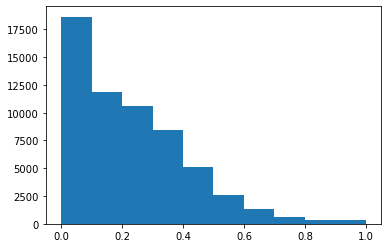

1


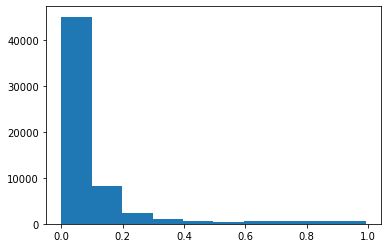

2


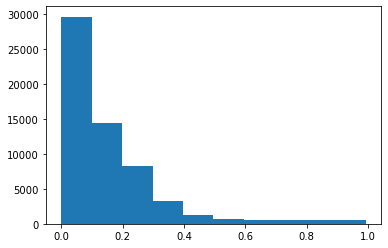

3


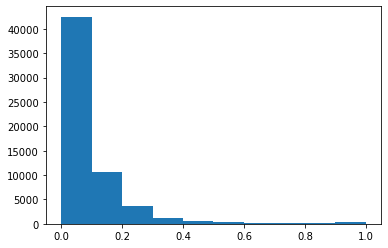

4


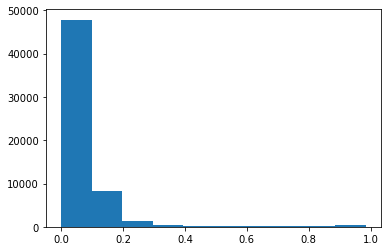

5


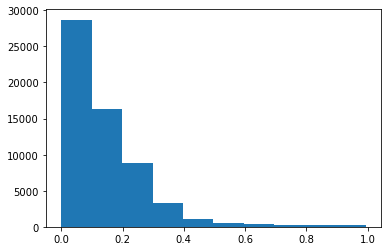

6


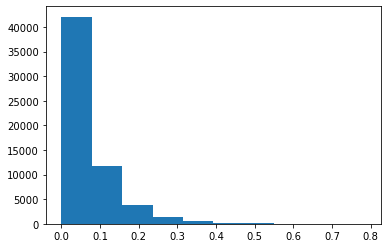

7


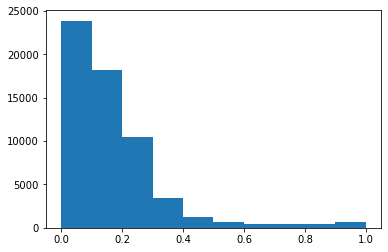

8


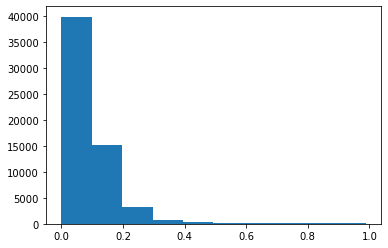

9


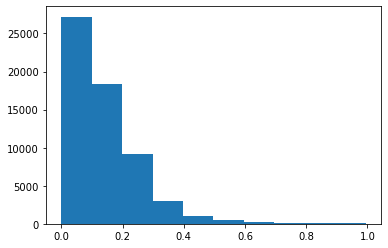

10


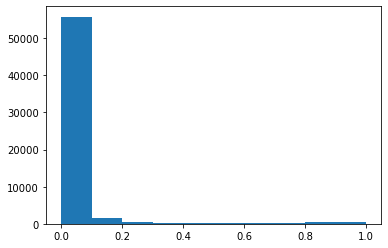

11


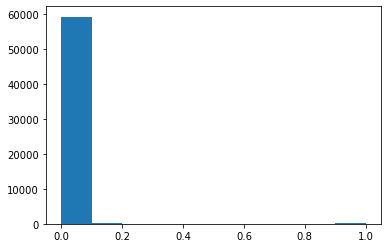

12


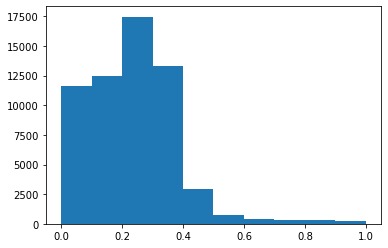

13


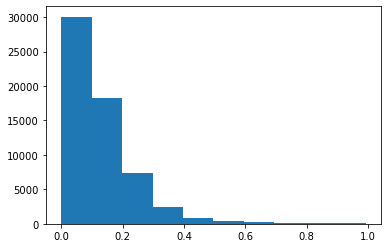

14


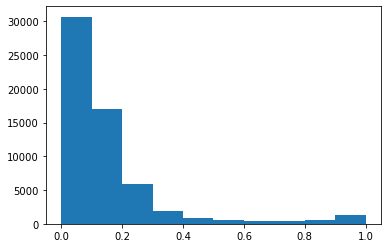

15


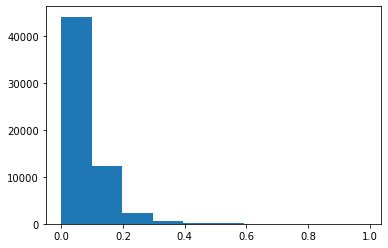

16


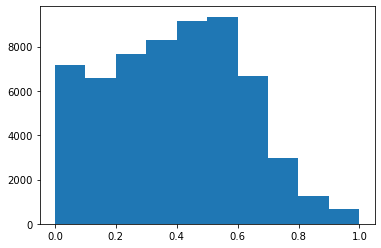

17


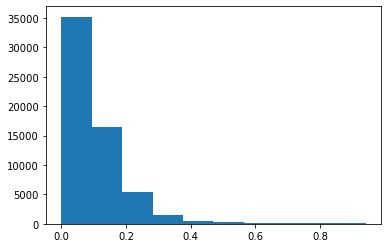

18


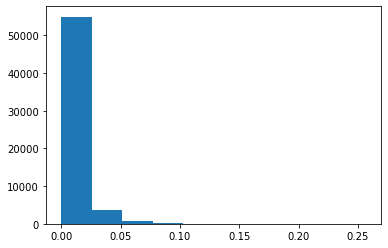

In [54]:
for i in range(19):
    print(i)
    plt.hist(exp19[f'{i}'])
    plt.show()

In [62]:
train_all_df[train_all_df['saved_label'].apply(lambda x: '18' in x)]

,saved_ID,saved_label,saved_path,common_ID,fold
7464,4876bcc0-bbb4-11e8-b2ba-ac1f6b6435d0_17,"['11', '18']",Nuclear/4876bcc0-bbb4-11e8-b2ba-ac1f6b6435d0_17,4876bcc0-bbb4-11e8-b2ba-ac1f6b6435d0,2.0
30884,44e2007a-bba4-11e8-b2b9-ac1f6b6435d0_0,"['11', '18']",Nucleoli/44e2007a-bba4-11e8-b2b9-ac1f6b6435d0_0,44e2007a-bba4-11e8-b2b9-ac1f6b6435d0,1.0
32598,448cf260-bba9-11e8-b2ba-ac1f6b6435d0_20,"['11', '18']",Golgi/448cf260-bba9-11e8-b2ba-ac1f6b6435d0_20,448cf260-bba9-11e8-b2ba-ac1f6b6435d0,4.0
34747,598e58ea-bbb1-11e8-b2ba-ac1f6b6435d0_8,"['11', '18']",Nuclear/598e58ea-bbb1-11e8-b2ba-ac1f6b6435d0_8,598e58ea-bbb1-11e8-b2ba-ac1f6b6435d0,4.0
34748,598e58ea-bbb1-11e8-b2ba-ac1f6b6435d0_54,"['11', '18']",Nuclear/598e58ea-bbb1-11e8-b2ba-ac1f6b6435d0_54,598e58ea-bbb1-11e8-b2ba-ac1f6b6435d0,4.0
...,...,...,...,...,...
271441,1469d230-bbc5-11e8-b2bc-ac1f6b6435d0_36,['18'],multi_masked_crop_bgr_256/1469d230-bbc5-11e8-b...,1469d230-bbc5-11e8-b2bc-ac1f6b6435d0,0.0
276672,173eb3ee-bbc6-11e8-b2bc-ac1f6b6435d0_6,['18'],multi_masked_crop_bgr_256/173eb3ee-bbc6-11e8-b...,173eb3ee-bbc6-11e8-b2bc-ac1f6b6435d0,1.0
280526,f80ffacc-bbc6-11e8-b2bc-ac1f6b6435d0_46,['18'],multi_masked_crop_bgr_256/f80ffacc-bbc6-11e8-b...,f80ffacc-bbc6-11e8-b2bc-ac1f6b6435d0,0.0
285694,1bff7588-bbc8-11e8-b2bc-ac1f6b6435d0_19,['18'],multi_masked_crop_bgr_256/1bff7588-bbc8-11e8-b...,1bff7588-bbc8-11e8-b2bc-ac1f6b6435d0,3.0


In [253]:
exp18 = pd.read_csv('OUTPUT/exp18_hpa_pred_single_label_for_to_multi_effnet5/all_fold_oof_df.csv')

In [254]:
exp18

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.310971,0.133751,0.368289,0.172648,0.089087,0.249831,0.228169,0.291281,0.305263,0.322809,0.164317,0.073575,0.396868,0.425822,0.372653,0.296350,0.512933,0.206990,0.073602
1,0.468630,0.085983,0.314614,0.208200,0.170676,0.240757,0.168576,0.247430,0.261982,0.307160,0.140413,0.087812,0.321871,0.376788,0.476960,0.156094,0.516922,0.151992,0.054939
2,0.279519,0.045411,0.419478,0.230814,0.110268,0.310938,0.180886,0.168395,0.181318,0.253865,0.059235,0.041195,0.379481,0.364816,0.477613,0.235682,0.571542,0.212651,0.036619
3,0.513574,0.154714,0.356894,0.165256,0.110624,0.199099,0.145998,0.315221,0.173834,0.270024,0.134229,0.102894,0.417984,0.332282,0.277731,0.137785,0.561318,0.204381,0.040066
4,0.434851,0.088615,0.212045,0.080049,0.092781,0.174896,0.176043,0.302336,0.171955,0.245000,0.036136,0.091092,0.409654,0.345218,0.487792,0.139259,0.589268,0.170382,0.015835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232526,0.348916,0.054361,0.321578,0.200797,0.135744,0.191439,0.190137,0.093639,0.168961,0.237804,0.488123,0.024471,0.209425,0.262713,0.128996,0.042065,0.805869,0.173847,0.008769
232527,0.632648,0.302736,0.242196,0.187819,0.144819,0.256041,0.182721,0.165686,0.143589,0.199117,0.169428,0.020213,0.250029,0.214045,0.144510,0.037843,0.721110,0.222809,0.009967
232528,0.687896,0.096151,0.170078,0.142004,0.067679,0.212182,0.141262,0.188628,0.104718,0.136661,0.177725,0.006944,0.216719,0.167184,0.093762,0.020342,0.808474,0.090589,0.001483
232529,0.573913,0.169995,0.243642,0.220895,0.095703,0.226248,0.154891,0.134217,0.117634,0.194572,0.386420,0.012934,0.233175,0.218540,0.102251,0.031344,0.754587,0.198023,0.006454


In [270]:
train_all_df.iloc[:,:3]

,saved_ID,saved_label,saved_path
0,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_0,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
1,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_1,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
2,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_2,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
3,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_3,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
4,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_4,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
...,...,...,...
232526,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_16,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...
232527,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_17,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...
232528,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_21,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...
232529,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_22,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...


In [271]:
single_to_multi_train_all_df = train_all_df.iloc[:,:3]

In [272]:
single_to_multi_train_all_df

,saved_ID,saved_label,saved_path
0,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_0,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
1,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_1,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
2,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_2,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
3,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_3,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
4,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_4,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...
...,...,...,...
232526,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_16,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...
232527,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_17,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...
232528,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_21,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...
232529,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_22,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...


In [273]:
single_to_multi_train_all_df = pd.concat([single_to_multi_train_all_df,exp18],axis=1)

In [274]:
single_to_multi_train_all_df

,saved_ID,saved_label,saved_path,0,1,2,3,4,5,6,...,9,10,11,12,13,14,15,16,17,18
0,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_0,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...,0.310971,0.133751,0.368289,0.172648,0.089087,0.249831,0.228169,...,0.322809,0.164317,0.073575,0.396868,0.425822,0.372653,0.296350,0.512933,0.206990,0.073602
1,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_1,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...,0.468630,0.085983,0.314614,0.208200,0.170676,0.240757,0.168576,...,0.307160,0.140413,0.087812,0.321871,0.376788,0.476960,0.156094,0.516922,0.151992,0.054939
2,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_2,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...,0.279519,0.045411,0.419478,0.230814,0.110268,0.310938,0.180886,...,0.253865,0.059235,0.041195,0.379481,0.364816,0.477613,0.235682,0.571542,0.212651,0.036619
3,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_3,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...,0.513574,0.154714,0.356894,0.165256,0.110624,0.199099,0.145998,...,0.270024,0.134229,0.102894,0.417984,0.332282,0.277731,0.137785,0.561318,0.204381,0.040066
4,5c801c04-bb99-11e8-b2b9-ac1f6b6435d0_4,[14],Mitochondria/5c801c04-bb99-11e8-b2b9-ac1f6b643...,0.434851,0.088615,0.212045,0.080049,0.092781,0.174896,0.176043,...,0.245000,0.036136,0.091092,0.409654,0.345218,0.487792,0.139259,0.589268,0.170382,0.015835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232526,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_16,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.348916,0.054361,0.321578,0.200797,0.135744,0.191439,0.190137,...,0.237804,0.488123,0.024471,0.209425,0.262713,0.128996,0.042065,0.805869,0.173847,0.008769
232527,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_17,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.632648,0.302736,0.242196,0.187819,0.144819,0.256041,0.182721,...,0.199117,0.169428,0.020213,0.250029,0.214045,0.144510,0.037843,0.721110,0.222809,0.009967
232528,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_21,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.687896,0.096151,0.170078,0.142004,0.067679,0.212182,0.141262,...,0.136661,0.177725,0.006944,0.216719,0.167184,0.093762,0.020342,0.808474,0.090589,0.001483
232529,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_22,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.573913,0.169995,0.243642,0.220895,0.095703,0.226248,0.154891,...,0.194572,0.386420,0.012934,0.233175,0.218540,0.102251,0.031344,0.754587,0.198023,0.006454


# make single to multi

In [298]:
cleaned_df[cleaned_df['saved_ID']=='8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_6'].saved_label

96    [0]
Name: saved_label, dtype: object

In [335]:
cleaned_df['saved_label'].map(str)

0             ['3']
1             ['3']
2             ['3']
3             ['3']
4             ['3']
           ...     
3219    ['9', '16']
3220    ['14', '0']
3221    ['14', '0']
3222    ['14', '0']
3223    ['14', '0']
Name: saved_label, Length: 3224, dtype: object

In [367]:
count

293

In [373]:
#0は残す！！ 149162もあるから
#0~5は残す！！　シングルラベルではラベルづけしなかったから
row_list = []
count = 0
for index, row in enumerate(single_to_multi_train_all_df.values):
    


    pred_confs = row[3:]
    if '11' in row[1]:#'11'の微妙なラインをどうするのか,
        #p1,細胞骨格（細胞質分裂ブリッジ）とりあえずconf低いのは含めない
        #p2 soft label 0.5にする
        #p3 含める
        if pred_confs[11] > 0.5:
            print(pred_confs)
            print(row[0])
            print(row[1])
            print(np.argsort(pred_confs)[::-1])
            row_list.append(row)
            count += 1
            print('===========')
            continue
            

    if np.sort(pred_confs)[::-1][0] > 0.8:#max低いのはdrop =>

        new_label = np.argsort(pred_confs)[::-1][np.sort(pred_confs)[::-1] >0.5]#single,multiどちらでも0.5以下はdrop
#         if '18' in row[1]:
#             print(row[0])
#             print(row[1])
#             print(np.sort(pred_confs)[::-1])
#             print(np.argsort(pred_confs)[::-1])
#             print(np.argsort(pred_confs)[::-1][np.sort(pred_confs)[::-1] >0.5])
#             print('===========')
        
    
        if str(np.argsort(pred_confs)[::-1][0]) == '11':
            if '11' not in row[1]:#handし損ねた'11'を11に
#                 print(row[0])
#                 print(row[1])
#                 print(np.sort(pred_confs)[::-1])
#                 print(np.argsort(pred_confs)[::-1])
#                 print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!_11')
                row[1] = ['11']
#                 print(row[1])
                #使うrow
                row_list.append(row)
#                 print('===========')
        else:
            new_label_list = []
            for kk in new_label:
                new_label_list.append(str(kk))
            row[1] = new_label_list
#             print(row[1])
            #使うrow
            row_list.append(row)
#             print('===========')
         #18
         #18はpredでは更新無理　confが低いから
         #handしたやつが間違ってるかもしれないから直す必要はある
            

#     if index == 10000:
#         break
cleaned_df = pd.DataFrame(row_list,columns=single_to_multi_train_all_df.columns.to_list())

[0.17290246 0.024989773 0.07445358 0.0034336788 0.026667548 0.021930043
 0.0014216794 0.016442657 0.03208358 0.14729221 0.08405882 0.95969206
 0.12305407 0.1030215 0.10551258 0.0010495179 0.16951342 0.011292953
 0.0007587658]
d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0_12
['11']
[11  0 16  9 12 14 13 10  2  8  4  1  5  7 17  3  6 15 18]
[0.1555194 0.021739792 0.064738825 0.00089807075 0.018606111 0.012980022
 0.00014244545 0.0046794694 0.012402825 0.0573908 0.0037977444 0.9852621
 0.05708346 0.08151841 0.05772422 0.0002056829 0.05781874 0.0010021881
 7.594506e-05]
dccab450-bb99-11e8-b2b9-ac1f6b6435d0_6
['11']
[11  0 13  2 16 14  9 12  1  4  5  8  7 10 17  3 15  6 18]
[0.0048072133 4.6230684e-13 1.343432e-10 7.036331e-21 3.1870967e-16
 1.0543336e-11 2.9111111000000003e-24 2.3206209e-14 8.0543983e-14
 2.9409672e-13 1.4170177e-22 0.9895858 1.0393878e-07 7.4049755e-10
 4.148185e-07 5.0005715999999996e-23 2.874226e-10 6.7304933e-20
 2.3870716e-36]
b973a4d4-bb9a-11e8-b2b9-ac1f6b6435d0_36
['11']
[11

[0.25460744 0.05428832 0.07542224 0.00346962 0.02361872 0.03845388
 0.0013074325 0.013123314 0.030691912 0.06748938 0.02181271 0.9489472
 0.08017362 0.07191272 0.15362194 0.0005800271 0.14641781 0.0021457311
 0.00035415456]
e93a48f6-bbab-11e8-b2ba-ac1f6b6435d0_12
['11']
[11  0 14 16 12  2 13  9  1  5  8  4 10  7  3 17  6 15 18]
[0.011599927 3.799518e-10 3.3654533e-08 7.665233700000001e-16
 3.7688077e-12 4.2243933e-09 7.09811e-18 5.7535716e-11 3.2712882e-10
 3.7742414e-09 8.969008e-16 0.99363965 6.798571e-06 4.944969e-07
 5.47121e-06 1.4232124e-17 4.4934993e-07 6.6957175e-15 8.709742e-27]
58d4713c-bbac-11e8-b2ba-ac1f6b6435d0_20
['11']
[11  0 12 14 13 16  2  5  9  1  8  7  4 17 10  3 15  6 18]
[0.10969733 0.004073512 0.010516666 8.0967286e-05 0.0014639322
 0.0051626167 4.727367e-05 0.0010314503 0.0056786225 0.01632072
 0.0036529321 0.984301 0.023291238 0.025278805 0.022829374 1.6316008e-05
 0.048374176 8.875448e-05 2.2817023e-06]
58d4713c-bbac-11e8-b2ba-ac1f6b6435d0_29
['11']
[11  0 16 1

3ea4fefe-bbba-11e8-b2ba-ac1f6b6435d0_29
['11']
[11  0 14 12 13 16  2  5  1  9  8  7  4 10 17  3  6 15 18]
[0.3088167 0.23730987 0.47319227 0.059286423 0.13809441 0.1083608
 0.10065785 0.13969396 0.20786448 0.1807026 0.12252246 0.67586356
 0.34650373 0.19955282 0.20155996 0.068508714 0.4477109 0.084236085
 0.05577752]
a50d740e-bbbb-11e8-b2ba-ac1f6b6435d0_32
['11']
[11  2 16 12  0  1  8 14 13  9  7  4 10  5  6 17 15  3 18]
[0.49219245 0.13531296 0.19955838 0.01978724 0.07403172 0.10253839
 0.003080727 0.05126661 0.059960254 0.086279534 0.020260692 0.8684561
 0.18238647 0.08382767 0.20054851 0.0067061535 0.13112599 0.009595384
 0.0060737375]
c393ef34-bbbb-11e8-b2ba-ac1f6b6435d0_7
['11']
[11  0 14  2 12  1 16  5  9 13  4  8  7 10  3 17 15 18  6]
[0.09937669 0.0007915615 0.003608918 2.1442158e-06 0.00011444157
 0.0009910346 1.5392844e-07 0.00013228584 0.00033490872 0.00050757406
 3.9917527e-06 0.99352276 0.002869829 0.0028028311 0.02615806
 2.0031943e-07 0.0028543232 8.9585524e-07 1.252055e

['11']
[11  0 14 12  2 16 13  1  5  9  8  4  7 10  3 17 15  6 18]
[0.019190637 2.1180618e-08 7.906185e-07 4.60518e-13 3.4000897e-10
 2.5608853e-07 6.4540052e-15 3.5473882e-09 2.403582e-08 6.389717e-08
 1.4694569e-12 0.9921717 1.030628e-05 5.6767967e-06 0.00023591996
 5.9579827e-15 3.475206e-06 2.295226e-13 5.9938374e-22]
3c433f62-bbca-11e8-b2bc-ac1f6b6435d0_4
['11']
[11  0 14 12 13 16  2  5  9  8  1  7  4 10  3 17  6 15 18]
[0.004962449 7.1138603e-13 2.3085192e-10 2.5571167e-20 6.405766e-16
 2.5574196e-11 1.9309115999999998e-23 5.3781188e-14 3.2822803e-13
 8.5315246e-13 1.2874081e-21 0.98704547 1.3809985e-07 2.0720543e-09
 9.3581093e-07 2.9543694000000004e-22 5.6817095e-10 1.2284958e-19
 2.514808e-35]
3c433f62-bbca-11e8-b2bc-ac1f6b6435d0_19
['11']
[11  0 14 12 13 16  2  5  9  1  8  7  4 17  3 10 15  6 18]
[0.3219511 0.20962228 0.18839185 0.01650686 0.10939736 0.09332812
 0.0035187867 0.037598062 0.053698156 0.12405783 0.09751219 0.9250237
 0.24516308 0.102404684 0.069152325 0.006805280

[0.03639126 2.335148e-06 2.0137628e-05 1.7294427e-10 1.09575836e-07
 6.128466e-06 1.11382206e-11 2.3436652e-07 1.3934769e-06 4.2363727e-06
 1.3119581e-09 0.9940253 0.00027986924 8.104369e-05 0.00037038227
 8.3091554e-12 0.00013539271 4.2000872e-10 6.453002000000001e-17]
a4349af6-bba9-11e8-b2ba-ac1f6b6435d0_0
['11']
[11  0 14 12 16 13  2  5  9  1  8  7  4 10 17  3  6 15 18]
[0.09729194 0.0020831516 0.0046735075 1.3098637e-05 0.00057964906
 0.0017298006 2.0035445e-06 0.00029971646 0.0009687743 0.0040833335
 0.00017546464 0.9924148 0.012163604 0.010171805 0.0127313975
 1.3474963e-06 0.012938806 1.5958878e-05 6.294384e-08]
a4349af6-bba9-11e8-b2ba-ac1f6b6435d0_16
['11']
[11  0 16 14 12 13  2  9  1  5  8  4  7 10 17  3  6 15 18]
[0.07782729 0.0006016512 0.0057871253 6.3777034e-06 0.00023654875
 0.0006360491 2.6476872e-07 0.00015831015 0.00039088493 0.0010795776
 1.553462e-05 0.9953678 0.0040212777 0.0033050904 0.04650018 4.8834534e-07
 0.00262579 5.0150575e-06 7.336772e-09]
f6208d02-bba9-11e

[0.06430223 0.0001378359 0.0007403441 2.0097244e-07 2.0879581e-05
 0.0002402413 1.993137e-08 2.1071024e-05 0.000112971655 0.0004323584
 4.1618746e-06 0.9946794 0.00094375137 0.0017934096 0.008436178
 5.59192e-09 0.0026019346 1.3392182e-07 1.32164e-11]
673a3184-bbb7-11e8-b2ba-ac1f6b6435d0_26
['11']
[11  0 14 16 13 12  2  9  5  1  8  7  4 10  3 17  6 15 18]
[0.10497138 0.0019634806 0.0077267047 1.6692038e-05 0.0007208584
 0.001669227 1.7038176e-06 0.0003901698 0.0011899511 0.005498886
 0.00024480265 0.9943353 0.007891755 0.008658072 0.028063156 1.0351622e-06
 0.013280704 2.4480596e-05 4.8235883e-08]
481c6b7c-bbb8-11e8-b2ba-ac1f6b6435d0_10
['11']
[11  0 14 16 13 12  2  9  1  5  8  4  7 10 17  3  6 15 18]
[0.06692886 0.00023759842 0.0007664579 2.3875978e-07 4.3541924e-05
 0.00022902586 3.194985e-08 3.322302e-05 0.00010802559 0.00053989823
 2.4827327e-06 0.9950944 0.0041252 0.0024315026 0.0032998913 2.7364234e-08
 0.0032061336 7.0583985e-07 4.5555924e-11]
89b70348-bbb9-11e8-b2ba-ac1f6b6435d

[11 16  0  9 12 13 14  2 10  8  1  5  7  4  6 17  3 15 18]
[0.18472081 0.024124127 0.06963519 0.0022625658 0.014147276 0.023919359
 0.0015485625 0.015683588 0.040960144 0.14426768 0.02536942 0.9522734
 0.099655 0.16889636 0.13232788 0.0009185881 0.17129828 0.0020341743
 0.00032158324]
1c88137a-bbc8-11e8-b2bc-ac1f6b6435d0_49
['11']
[11  0 16 13  9 14 12  2  8 10  1  5  7  4  3 17  6 15 18]
[0.16587408 0.0074420637 0.01972888 0.00010306014 0.0039114943 0.008720398
 1.1127757e-05 0.0012640159 0.0038255588 0.0052463096 0.0027233749
 0.98547715 0.025107745 0.008921787 0.010951316 1.1643115e-05 0.022693334
 8.690875e-05 1.9406925e-06]
b497bc74-bbc8-11e8-b2bc-ac1f6b6435d0_1
['11']
[11  0 12 16  2 14 13  5  1  9  4  8 10  7  3 17 15  6 18]
[0.053351942 5.151323e-05 0.0002658258 3.377098e-08 3.2919527e-06
 0.00010088286 1.9723465e-09 6.699148e-06 2.4868414e-05 7.889187e-05
 1.7034205e-07 0.9952727 0.0010590245 0.0007034722 0.0040556635
 2.4497198e-09 0.0006893335 3.1782243e-08 1.3085057e-12]
4c

94a6c720-bba5-11e8-b2ba-ac1f6b6435d0_26
['11']
[11  0 14 13 16 12  2  5  9  1  8  7  4 10  3 17  6 15 18]
[0.15476058 0.0039450894 0.01088495 5.5504206e-05 0.0008734746
 0.0049826265 7.744966e-06 0.0010921314 0.0027683147 0.008607216
 0.001082314 0.98749626 0.013264161 0.01104857 0.036761902 4.154147e-06
 0.024159756 4.039006e-05 4.5408055e-07]
a2f766cc-bba5-11e8-b2ba-ac1f6b6435d0_1
['11']
[11  0 14 16 12 13  2  9  5  1  8  7 10  4  3 17  6 15 18]
[0.021469392 2.124986e-08 8.42414e-07 6.807233e-14 1.3633261e-10
 1.4121446e-07 4.785694e-16 1.881087e-09 5.346767e-09 2.389363e-08
 2.4245171e-14 0.993282 1.7911947e-05 8.6705395e-06 3.715489e-05
 4.9452655e-15 1.0748863e-06 1.0831695e-13 4.2643560000000004e-23]
4114feb4-bba6-11e8-b2ba-ac1f6b6435d0_4
['11']
[11  0 14 12 13 16  2  5  9  1  8  7  4 17  3 10 15  6 18]
[0.14520866 0.011929342 0.018707672 0.00010309496 0.0025274996 0.009910394
 1.2003749e-05 0.0017451163 0.0037979512 0.015149213 0.0006375218
 0.9881657 0.030561231 0.033300757 0.0

[0.06405576 9.930965e-05 0.0014320503 1.407182e-07 2.2764812e-05
 0.00032789592 1.2850231e-08 2.6194419e-05 0.00010805375 0.00018671899
 1.1546854e-06 0.9945804 0.0008420503 0.0025234055 0.0030569497
 1.4978802e-08 0.0014973977 5.219214e-08 3.2894822e-11]
5914c132-bbb7-11e8-b2ba-ac1f6b6435d0_2
['11']
[11  0 14 13 16  2 12  5  9  8  1  7  4 10  3 17 15  6 18]
[0.10632643 0.0011068183 0.009418266 2.4337685e-06 0.00027319734
 0.0024046367 1.7512467e-07 0.00019530955 0.0006191789 0.0010338372
 6.1545998e-06 0.9930195 0.003902988 0.011767296 0.0070979865
 4.1660797e-07 0.004711083 6.5319966e-07 2.428692e-09]
5914c132-bbb7-11e8-b2ba-ac1f6b6435d0_6
['11']
[11  0 13  2 14 16 12  5  1  9  8  4  7 10  3 17 15  6 18]
[0.1389965 0.0032144503 0.019555297 3.6677906e-05 0.0009578925 0.005119069
 3.6935794e-06 0.0007821997 0.0022790607 0.003683038 0.0002975613
 0.99076146 0.008093558 0.010536433 0.028460389 4.1438893e-06 0.012601763
 1.6803086e-05 3.3502116e-07]
30e4641e-bbb8-11e8-b2ba-ac1f6b6435d0_3


[0.4135728 0.13557032 0.21945018 0.020252375 0.07402888 0.15280917
 0.0072789053 0.0746251 0.078791365 0.1375248 0.053504247 0.80722046
 0.22305925 0.13629599 0.148278 0.008991881 0.26027218 0.014325107
 0.0074846596]
534a9442-bbc7-11e8-b2bc-ac1f6b6435d0_6
['11']
[11  0 16 12  2  5 14  9 13  1  8  7  4 10  3 17 15 18  6]
[0.008349104 1.9042386e-11 1.5186601e-09 6.885196e-19 2.8042855e-14
 2.0648942e-10 6.159034e-22 5.1553147e-13 2.643455e-12 6.13173e-12
 1.2683366e-19 0.99159974 1.8914642e-07 6.582648e-09 1.2364992e-06
 5.248489e-21 2.374856e-09 4.529421e-18 2.1671326e-32]
534a9442-bbc7-11e8-b2bc-ac1f6b6435d0_45
['11']
[11  0 14 12 13 16  2  5  1  9  8  7  4 17  3 10 15  6 18]
[0.22154969 0.031978823 0.041142013 0.00089813437 0.011076759 0.025038984
 4.9023725e-05 0.004475872 0.008792009 0.021207262 0.0034620764 0.98251367
 0.05229506 0.027180737 0.0620328 0.00020097726 0.02213976 0.0006154087
 8.697188e-05]
c755241e-bbc8-11e8-b2bc-ac1f6b6435d0_7
['11']
[11  0 14 12  2  1 13  5 16  9  

[0.0953285 0.0023646273 0.0056888824 1.794311e-05 0.00037236552
 0.0037028906 1.6447063e-06 0.00045982792 0.0014798531 0.0066673583
 0.00011373835 0.9883923 0.013908607 0.027293816 0.0271091 4.202992e-06
 0.007872107 7.232586e-06 8.0707345e-08]
41060e2e-bba4-11e8-b2b9-ac1f6b6435d0_6
['11']
[11  0 13 14 12 16  9  2  5  1  8  7  4 10  3 17 15  6 18]
[0.19174258 0.024218254 0.08205791 0.0028646677 0.020362878 0.03140543
 0.0019644739 0.014842043 0.049682982 0.16640848 0.0407162 0.9385334
 0.14735356 0.21241595 0.08279412 0.0014651433 0.22662625 0.002863145
 0.0005133628]
979b85c0-bba4-11e8-b2b9-ac1f6b6435d0_15
['11']
[11 16 13  0  9 12 14  2  8 10  5  1  4  7  3 17  6 15 18]
[0.16488618 0.010352259 0.027877524 0.0001964422 0.0037637984 0.0123946285
 3.5936013e-05 0.003809223 0.0067225015 0.01207941 0.0027103939 0.9838814
 0.037101258 0.024913011 0.035660967 5.867979e-05 0.026994295
 0.00017480942 9.127643e-06]
c27aa348-bba4-11e8-b2ba-ac1f6b6435d0_2
['11']
[11  0 12 14  2 16 13  5  9  1  8

[0.016537251 2.1938726e-10 1.3888031e-07 4.166104e-16 5.5242412e-12
 6.8329444e-09 5.553258999999999e-19 1.1557674e-10 1.6704502e-10
 2.108029e-10 5.481504e-17 0.9897499 1.9892213e-06 1.2521895e-07
 1.1190688e-05 1.473878e-17 4.213625e-08 1.9776894e-15
 2.5884481000000003e-27]
4342233a-bbb3-11e8-b2ba-ac1f6b6435d0_12
['11']
[11  0 14 12  2 13 16  5  1  9  8  7  4 17  3 10 15  6 18]
[0.3933812 0.16975479 0.2495645 0.052277632 0.17451958 0.1694625
 0.0057288813 0.06590021 0.091088936 0.19793043 0.12243218 0.85887367
 0.31983355 0.14361928 0.16483545 0.03066764 0.14132898 0.05583535
 0.06320502]
99d7de24-bbb3-11e8-b2ba-ac1f6b6435d0_28
['11', '18']
[11  0 12  2  9  4  1  5 14 13 16 10  8  7 18 17  3 15  6]
[0.14968781 0.0052737463 0.024237888 0.00025961024 0.0037520581
 0.0065508825 0.00011224654 0.002661515 0.014046554 0.051315445
 0.019529697 0.9753398 0.031199723 0.04680542 0.046891768 3.0109475e-05
 0.09551441 0.00031588486 6.1520145e-06]
a53f4856-bbb3-11e8-b2ba-ac1f6b6435d0_5
['11']
[1

[0.16318807 0.009347838 0.009350922 6.077497e-05 0.0011219627 0.0060168323
 4.7053995e-06 0.00089091866 0.0018802638 0.010583067 0.0005601704
 0.98854077 0.024033926 0.015316251 0.022861946 5.5648575e-06 0.019126017
 7.03106e-05 4.7415915e-07]
a1b9245c-bbc4-11e8-b2bc-ac1f6b6435d0_13
['11']
[11  0 12 14 16 13  9  2  1  5  8  4  7 10 17  3 15  6 18]
[0.08276464 0.0007177894 0.0015058065 4.8607296e-07 5.6694516e-05
 0.0006504047 9.392048e-09 3.301325e-05 7.798406e-05 0.00023580679
 3.0827064e-06 0.99498737 0.0013369633 0.0013056761 0.0044460814
 2.1905658e-08 0.00086715387 3.9837673e-07 1.2390827e-10]
d497d486-bbc4-11e8-b2bc-ac1f6b6435d0_28
['11']
[11  0 14  2 12 13 16  1  5  9  8  4  7 10  3 17 15  6 18]
[0.15357101 0.01159928 0.013831972 5.3222964e-05 0.0018816271 0.00707734
 2.454049e-06 0.0007846002 0.0016199556 0.004153356 0.000454815 0.9901136
 0.012539074 0.008783943 0.01682407 4.857295e-06 0.008523281 4.5313413e-05
 5.798082e-07]
d497d486-bbc4-11e8-b2bc-ac1f6b6435d0_34
['11']
[11 

[0.45357072 0.28055692 0.38877258 0.06165432 0.18762057 0.23415661
 0.01755767 0.09353974 0.15368587 0.13649638 0.0972775 0.7062795
 0.34813535 0.14053628 0.10107724 0.060062278 0.21522671 0.04216253
 0.07798842]
abc11bd4-bba2-11e8-b2b9-ac1f6b6435d0_15
['11']
[11  0  2 12  1  5 16  4  8 13  9 14 10  7 18  3 15 17  6]
[0.016055308 2.5107334e-09 5.4904138e-08 1.2843963e-15 1.2570801e-11
 9.863129e-09 3.7941708e-18 6.89316e-11 2.568623e-10 1.1271919e-09
 1.034622e-15 0.9939966 3.2454782e-06 1.855305e-07 5.8001087e-06
 1.4272887e-17 1.5267649e-07 1.1500099e-14 2.3754069e-26]
bc17b79a-bba2-11e8-b2b9-ac1f6b6435d0_16
['11']
[11  0 14 12 13 16  2  5  1  9  8  7  4 17  3 10 15  6 18]
[0.07832371 0.00045055748 0.00202122 8.5445924e-07 7.262182e-05
 0.00054129225 5.2329177e-08 5.6404653e-05 0.00017415662 0.00045162148
 1.0221603e-05 0.9953097 0.0031234743 0.002135352 0.0064827413
 7.4775905e-08 0.0021666256 1.1393319e-06 4.3742351e-10]
db698ad8-bba2-11e8-b2b9-ac1f6b6435d0_25
['11']
[11  0 14 12 1

[0.0020688046 1.9587971e-15 1.0464374e-12 3.2541013e-24 1.2703691e-18
 8.487537e-14 8.095965000000001e-28 2.322639e-16 6.366601e-16 5.305691e-15
 1.6266521000000002e-26 0.98632133 6.2471415e-08 2.4788163e-11
 3.6657156e-08 4.0385226000000004e-26 1.28724505e-11 3.3173815e-22 0.0]
e69b5bf0-bbb3-11e8-b2ba-ac1f6b6435d0_18
['11']
[11  0 12 14 13 16  2  5  9  1  8  7  4 17  3 15 10  6 18]
[0.056905426 0.00020048913 0.0005891761 2.872069e-07 1.36389235e-05
 0.00027253886 3.9319847e-08 1.6788672e-05 0.00014196079 0.00055859354
 1.1055358e-05 0.99350995 0.0015247902 0.001662106 0.006313454
 1.3143203e-08 0.0027298443 2.6727022e-07 5.3354824e-11]
4db910fc-bbb4-11e8-b2ba-ac1f6b6435d0_23
['11']
[11  0 14 16 13 12  2  9  5  1  8  7  4 10  3 17  6 15 18]
[0.034473542 1.2295429e-06 8.867275e-06 1.2717047e-11 1.7004831e-08
 2.3264793e-06 1.7780322e-13 2.4567871e-08 1.4918811e-07 4.885464e-07
 4.812116e-11 0.9960363 2.6260512e-05 1.9569565e-05 0.00014964712
 9.1802996e-14 2.3296589e-05 1.1628832e-11 2.

[0.19104975 0.051458683 0.04145112 0.0006787731 0.0107655665 0.016578577
 9.501778e-05 0.00329907 0.009561181 0.018665059 0.009618825 0.9835682
 0.055866543 0.01683568 0.03913632 0.00011832059 0.03723062 0.0014772224
 6.250968e-05]
e76e108a-bbc3-11e8-b2bc-ac1f6b6435d0_18
['11']
[11  0 12  1  2 14 16  9 13  5  4 10  8  7 17  3 15  6 18]
[0.0046731164 6.923831e-13 7.522439e-11 7.5771505e-21
 2.1606318000000002e-16 1.3900905e-11 1.2269381e-23 2.2694313e-14
 2.0018377e-13 1.1188266e-12 7.148166300000001e-22 0.98902583 6.86064e-08
 1.5061694e-09 8.907484e-07 2.2873224e-23 1.1017968e-09 3.3827842e-20
 1.6140542e-36]
20583ea2-bbc4-11e8-b2bc-ac1f6b6435d0_15
['11']
[11  0 14 12 13 16  2  5  9  1  8  7  4 17  3 10 15  6 18]
[0.09169961 0.0014716387 0.0038549246 2.5201918e-05 0.00016345666
 0.0009700025 1.5444762e-06 0.0003241934 0.0007106819 0.0024581198
 9.931175e-06 0.98527235 0.0038813057 0.0056421245 0.41813666
 1.2316411e-06 0.003341432 5.3813073e-06 1.9688747e-08]
25eee5b4-bbc4-11e8-b2bc-a

In [378]:
count

774

In [379]:
cleaned_df

,saved_ID,saved_label,saved_path,0,1,2,3,4,5,6,...,9,10,11,12,13,14,15,16,17,18
0,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,[3],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,0.316977,0.016934,0.192615,0.873722,0.093143,0.128005,0.129525,...,0.158277,0.062185,0.000141,0.321868,0.177203,0.274463,0.066650,0.327378,0.126682,0.003763
1,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,[3],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,0.403954,0.041080,0.243623,0.844879,0.073550,0.151004,0.114991,...,0.187797,0.159048,0.000180,0.295957,0.172990,0.187489,0.058751,0.326228,0.196300,0.005445
2,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,[3],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,0.332009,0.034281,0.180504,0.870063,0.034491,0.088983,0.131941,...,0.143544,0.147286,0.000062,0.386312,0.158026,0.163239,0.059237,0.285488,0.150833,0.002591
3,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,[3],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,0.463737,0.027789,0.201427,0.839427,0.064601,0.077552,0.061613,...,0.251961,0.183666,0.000234,0.284851,0.187846,0.209962,0.025999,0.310473,0.161664,0.002639
4,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,[3],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,0.289294,0.019537,0.151936,0.864847,0.035854,0.070772,0.117137,...,0.197871,0.123910,0.000047,0.299855,0.217347,0.183945,0.036513,0.386415,0.148252,0.001011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70618,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_14,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.482113,0.036688,0.196309,0.164088,0.068386,0.186005,0.134494,...,0.148099,0.185877,0.002458,0.131212,0.158413,0.080572,0.010212,0.892577,0.139814,0.000472
70619,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_15,"[16, 0]",to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.656039,0.068905,0.163816,0.089355,0.106277,0.182861,0.128227,...,0.199852,0.075516,0.015362,0.221528,0.306007,0.160420,0.028120,0.807746,0.145542,0.002051
70620,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_16,[16],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.348916,0.054361,0.321578,0.200797,0.135744,0.191439,0.190137,...,0.237804,0.488123,0.024471,0.209425,0.262713,0.128996,0.042065,0.805869,0.173847,0.008769
70621,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_21,"[16, 0]",to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.687896,0.096151,0.170078,0.142004,0.067679,0.212182,0.141262,...,0.136661,0.177725,0.006944,0.216719,0.167184,0.093762,0.020342,0.808474,0.090589,0.001483


In [376]:
def find_label(label):
    return ('11' in label)

In [377]:
cleaned_df[cleaned_df['saved_label'].apply(find_label)]

,saved_ID,saved_label,saved_path,0,1,2,3,4,5,6,...,9,10,11,12,13,14,15,16,17,18
171,d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0_12,[11],Cytosol/d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0_12,0.172902,2.498977e-02,7.445358e-02,3.433679e-03,2.666755e-02,2.193004e-02,1.421679e-03,...,1.472922e-01,8.405882e-02,0.959692,1.230541e-01,1.030215e-01,1.055126e-01,1.049518e-03,1.695134e-01,1.129295e-02,7.587658e-04
173,dccab450-bb99-11e8-b2b9-ac1f6b6435d0_6,[11],Nucleoli/dccab450-bb99-11e8-b2b9-ac1f6b6435d0_6,0.155519,2.173979e-02,6.473882e-02,8.980707e-04,1.860611e-02,1.298002e-02,1.424454e-04,...,5.739080e-02,3.797744e-03,0.985262,5.708346e-02,8.151841e-02,5.772422e-02,2.056829e-04,5.781874e-02,1.002188e-03,7.594506e-05
414,b973a4d4-bb9a-11e8-b2b9-ac1f6b6435d0_36,[11],Mitochondria/b973a4d4-bb9a-11e8-b2b9-ac1f6b643...,0.004807,4.623068e-13,1.343432e-10,7.036331e-21,3.187097e-16,1.054334e-11,2.911111e-24,...,2.940967e-13,1.417018e-22,0.989586,1.039388e-07,7.404976e-10,4.148185e-07,5.000572e-23,2.874226e-10,6.730493e-20,2.387072e-36
830,76a43194-bb9c-11e8-b2b9-ac1f6b6435d0_3,[11],Nucleoli/76a43194-bb9c-11e8-b2b9-ac1f6b6435d0_3,0.027630,3.048156e-07,4.356245e-06,2.888983e-12,2.449491e-09,1.264635e-06,4.315679e-14,...,1.215516e-07,5.895468e-12,0.993912,1.876854e-05,1.242694e-05,2.525335e-04,6.341122e-14,7.002011e-06,1.720515e-12,2.014952e-20
839,84b49e36-bb9c-11e8-b2b9-ac1f6b6435d0_34,[11],Centrosome/84b49e36-bb9c-11e8-b2b9-ac1f6b6435d...,0.026565,5.768385e-09,2.134795e-06,2.196063e-14,2.256854e-10,1.112096e-07,4.946640e-17,...,1.224866e-09,2.840411e-14,0.992133,1.902535e-06,3.752342e-07,1.904653e-05,3.377449e-16,3.076324e-07,3.936028e-14,4.286985e-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70508,9dbad7fc-bba0-11e8-b2b9-ac1f6b6435d0_10,[11],to_hand_label_11/9dbad7fc-bba0-11e8-b2b9-ac1f6...,0.068746,2.853369e-04,6.777410e-04,2.703406e-07,1.628476e-05,4.443664e-04,9.930046e-09,...,3.335464e-04,6.310096e-06,0.993655,1.427460e-03,1.418638e-03,5.192781e-03,7.893160e-09,1.498749e-03,1.805321e-07,2.176281e-11
70511,9dbad7fc-bba0-11e8-b2b9-ac1f6b6435d0_17,[11],to_hand_label_11/9dbad7fc-bba0-11e8-b2b9-ac1f6...,0.040210,1.355111e-05,4.928499e-05,1.904686e-09,3.074564e-07,2.620126e-05,4.765793e-11,...,9.259991e-06,2.600212e-08,0.994781,1.679583e-04,1.027801e-04,1.153893e-03,3.029263e-11,1.351210e-04,1.368422e-09,3.814422e-15
70534,3865ad24-bba4-11e8-b2b9-ac1f6b6435d0_31,[11],to_hand_label_11/3865ad24-bba4-11e8-b2b9-ac1f6...,0.374222,2.708865e-01,2.108227e-01,4.631725e-02,1.372975e-01,1.422097e-01,1.846319e-02,...,3.102418e-01,3.305262e-01,0.792024,2.479597e-01,2.004919e-01,1.751736e-01,1.808674e-02,2.775532e-01,6.542785e-02,4.402230e-02
70605,19e9765e-bbc3-11e8-b2bc-ac1f6b6435d0_35,[11],to_hand_label_11/19e9765e-bbc3-11e8-b2bc-ac1f6...,0.305532,5.355277e-02,1.790385e-01,1.127038e-02,6.771579e-02,7.078998e-02,8.100391e-03,...,2.159813e-01,2.997318e-01,0.875158,1.665573e-01,1.832342e-01,1.059323e-01,7.278977e-03,2.697514e-01,1.622094e-02,7.825982e-03


In [381]:
cleaned_df['saved_label'] = cleaned_df['saved_label'].map(str)

In [382]:
cleaned_df

,saved_ID,saved_label,saved_path,0,1,2,3,4,5,6,...,9,10,11,12,13,14,15,16,17,18
0,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,0.316977,0.016934,0.192615,0.873722,0.093143,0.128005,0.129525,...,0.158277,0.062185,0.000141,0.321868,0.177203,0.274463,0.066650,0.327378,0.126682,0.003763
1,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,0.403954,0.041080,0.243623,0.844879,0.073550,0.151004,0.114991,...,0.187797,0.159048,0.000180,0.295957,0.172990,0.187489,0.058751,0.326228,0.196300,0.005445
2,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,0.332009,0.034281,0.180504,0.870063,0.034491,0.088983,0.131941,...,0.143544,0.147286,0.000062,0.386312,0.158026,0.163239,0.059237,0.285488,0.150833,0.002591
3,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,0.463737,0.027789,0.201427,0.839427,0.064601,0.077552,0.061613,...,0.251961,0.183666,0.000234,0.284851,0.187846,0.209962,0.025999,0.310473,0.161664,0.002639
4,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,0.289294,0.019537,0.151936,0.864847,0.035854,0.070772,0.117137,...,0.197871,0.123910,0.000047,0.299855,0.217347,0.183945,0.036513,0.386415,0.148252,0.001011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70618,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_14,['16'],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.482113,0.036688,0.196309,0.164088,0.068386,0.186005,0.134494,...,0.148099,0.185877,0.002458,0.131212,0.158413,0.080572,0.010212,0.892577,0.139814,0.000472
70619,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_15,"['16', '0']",to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.656039,0.068905,0.163816,0.089355,0.106277,0.182861,0.128227,...,0.199852,0.075516,0.015362,0.221528,0.306007,0.160420,0.028120,0.807746,0.145542,0.002051
70620,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_16,['16'],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.348916,0.054361,0.321578,0.200797,0.135744,0.191439,0.190137,...,0.237804,0.488123,0.024471,0.209425,0.262713,0.128996,0.042065,0.805869,0.173847,0.008769
70621,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_21,"['16', '0']",to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,0.687896,0.096151,0.170078,0.142004,0.067679,0.212182,0.141262,...,0.136661,0.177725,0.006944,0.216719,0.167184,0.093762,0.020342,0.808474,0.090589,0.001483


In [385]:
only_single_train_df = cleaned_df.iloc[:,:3]

In [387]:
def split_str(df):
    common_path = df.split('_')[0]
    return common_path

In [389]:
only_single_train_df['common_ID'] = only_single_train_df['saved_ID'].map(split_str)

In [390]:
only_single_train_df

,saved_ID,saved_label,saved_path,common_ID
0,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
1,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
2,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
3,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
4,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
...,...,...,...,...
70618,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_14,['16'],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0
70619,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_15,"['16', '0']",to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0
70620,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_16,['16'],to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0
70621,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_21,"['16', '0']",to_hand_label_11/44b5e136-bbca-11e8-b2bc-ac1f6...,44b5e136-bbca-11e8-b2bc-ac1f6b6435d0


In [392]:
only_multi_train_df = only_multi_train_df.iloc[:,:4]

In [395]:
single_and_multi_df = pd.concat([only_single_train_df,only_multi_train_df],axis = 0).reset_index(drop=True)

In [396]:
single_and_multi_df

,saved_ID,saved_label,saved_path,common_ID
0,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
1,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
2,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
3,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
4,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0
...,...,...,...,...
298838,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_27,"['5', '0']",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0
298839,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_28,"['5', '0', '4']",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0
298840,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_29,"['5', '0']",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0
298841,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_30,"['5', '0']",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0


# make fold

In [397]:
import numpy as np
from sklearn.model_selection import GroupKFold
#make group k_fold
id_list = single_and_multi_df.common_ID.value_counts().index

FOLDS = 5
for k in range(len(id_list)):
    single_and_multi_df.loc[single_and_multi_df.common_ID==id_list[k],'fold'] = k%FOLDS

In [399]:
single_and_multi_df.to_csv('single_and_multi_df.csv',index=False)

In [400]:
single_and_multi_df

,saved_ID,saved_label,saved_path,common_ID,fold
0,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_4,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0,3.0
1,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_6,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0,3.0
2,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_9,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0,3.0
3,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_10,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0,3.0
4,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,['3'],Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_12,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0,3.0
...,...,...,...,...,...
298838,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_27,"['5', '0']",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0,2.0
298839,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_28,"['5', '0', '4']",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0,2.0
298840,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_29,"['5', '0']",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0,2.0
298841,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_30,"['5', '0']",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0,2.0


In [404]:
single_and_multi_df.saved_label.value_counts()

['16', '0']                26062
['0']                      16633
['2', '0']                 14132
['7', '0']                 11102
['12', '0']                10633
                           ...  
['2', '13', '9']               1
['9', '16', '3', '14']         1
['12', '6', '1']               1
['10', '16', '2', '13']        1
['7', '0', '13', '3']          1
Name: saved_label, Length: 1720, dtype: int64

0


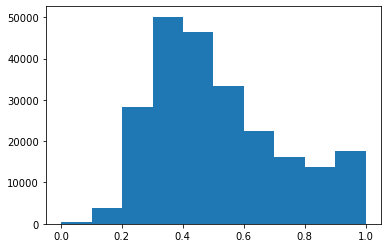

1


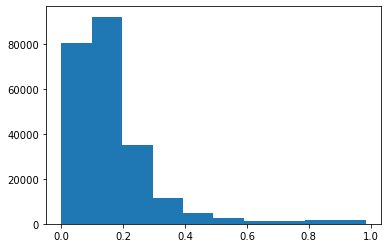

2


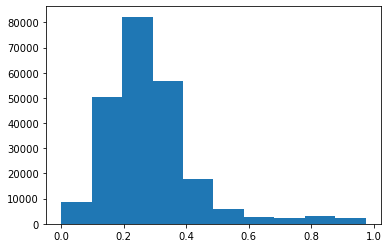

3


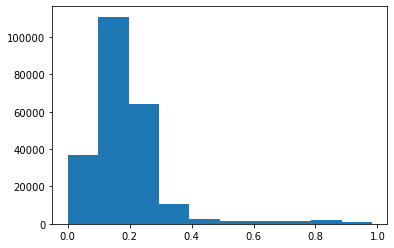

4


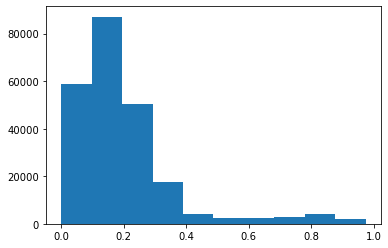

5


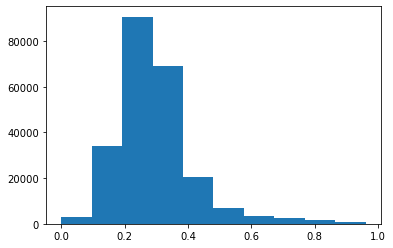

6


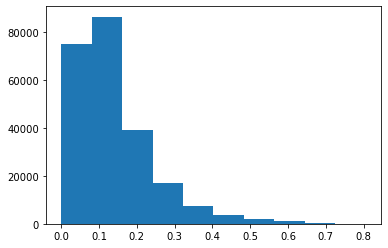

7


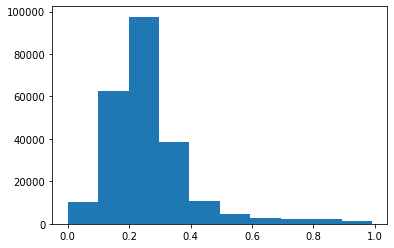

8


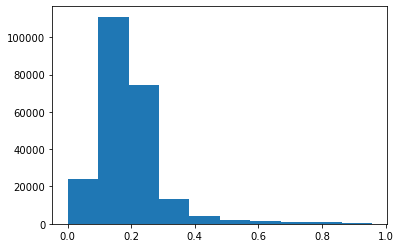

9


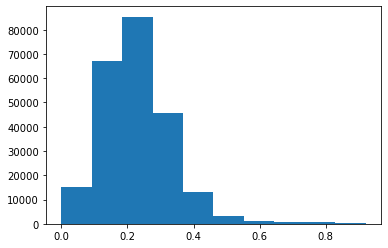

10


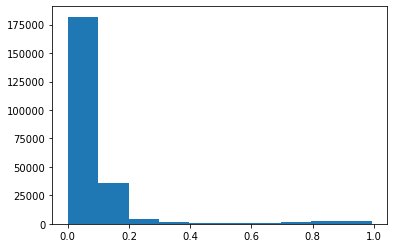

11


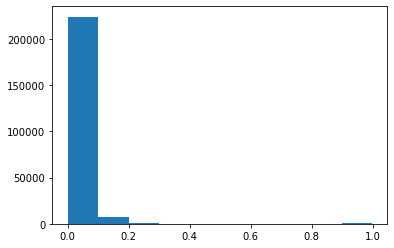

12


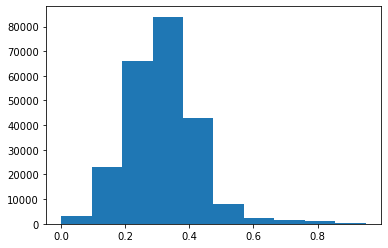

13


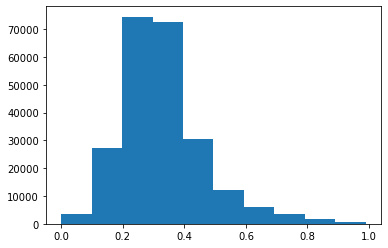

14


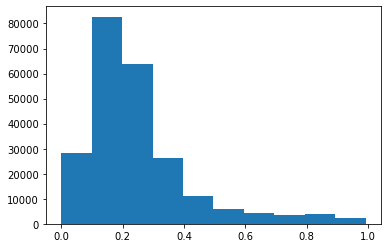

15


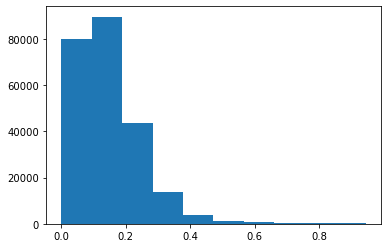

16


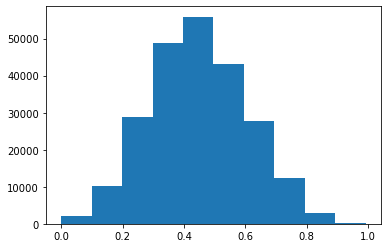

17


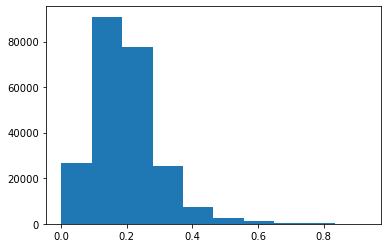

18


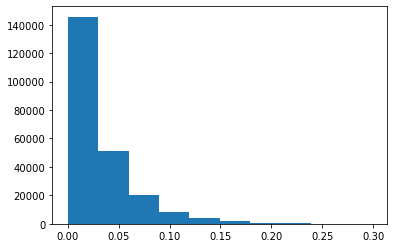

In [176]:
for i in range(19):
    print(i)
    plt.hist(exp18[f'{i}'])
    plt.show()

In [115]:
exp15 = pd.read_csv('OUTPUT/exp15_hpa_step2_G5fold_MY_norm_std_dropout_effnet5_relabeled/fold0_oof_df.csv')

In [116]:
exp15

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.063393,0.014908,0.024455,0.059614,0.028685,0.102498,0.210451,0.266598,0.161477,0.221312,0.057971,0.017888,0.146118,0.277005,0.686133,0.032673,0.177826,0.120542,0.015189
1,0.261295,0.067845,0.121851,0.175238,0.135578,0.207007,0.259935,0.266502,0.200242,0.246453,0.160393,0.074683,0.272688,0.294261,0.425664,0.067337,0.337605,0.222324,0.086573
2,0.087623,0.048613,0.116450,0.156212,0.079245,0.274968,0.357273,0.271284,0.203696,0.131332,0.180857,0.048545,0.255023,0.263397,0.357513,0.063712,0.355484,0.143206,0.078542
3,0.508725,0.114920,0.167037,0.167900,0.138671,0.267510,0.149586,0.328806,0.113900,0.096190,0.108967,0.087050,0.255244,0.184495,0.283834,0.052371,0.263855,0.162272,0.097243
4,0.057036,0.005198,0.094800,0.040964,0.022672,0.069346,0.088715,0.111113,0.052344,0.046812,0.022813,0.031105,0.082789,0.113888,0.884526,0.012971,0.082818,0.032909,0.010557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46381,0.316768,0.027894,0.073156,0.051951,0.058651,0.151652,0.134483,0.144757,0.121011,0.096901,0.474559,0.106462,0.142102,0.233502,0.119416,0.011924,0.486599,0.118818,0.171269
46382,0.154563,0.001009,0.010643,0.012830,0.008288,0.031284,0.080166,0.057270,0.059702,0.056879,0.104266,0.055915,0.045472,0.174912,0.067015,0.001544,0.794631,0.023690,0.067806
46383,0.293141,0.014340,0.044701,0.045065,0.044841,0.138756,0.137792,0.152087,0.121933,0.123810,0.210399,0.081757,0.205677,0.246633,0.120967,0.015390,0.578248,0.093245,0.107074
46384,0.258093,0.006290,0.050264,0.065979,0.042068,0.113666,0.109847,0.115560,0.072993,0.083575,0.080477,0.097252,0.120946,0.203992,0.095391,0.009283,0.716720,0.044965,0.147649


0


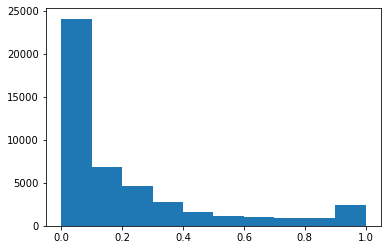

1


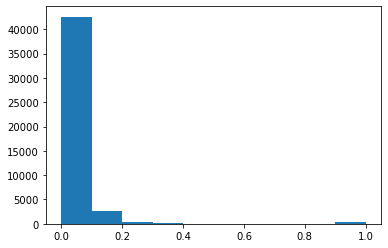

2


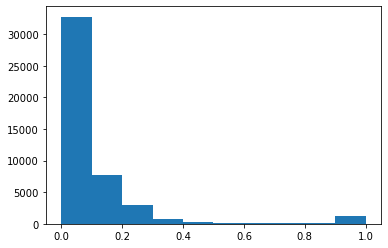

3


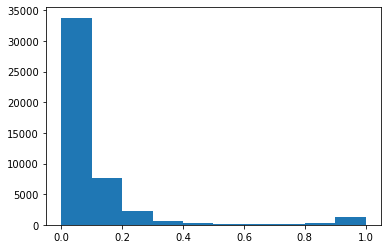

4


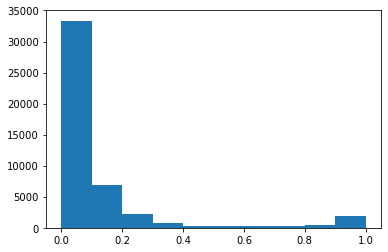

5


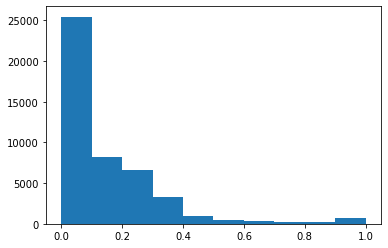

6


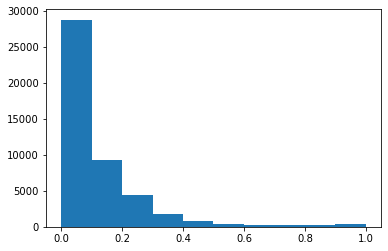

7


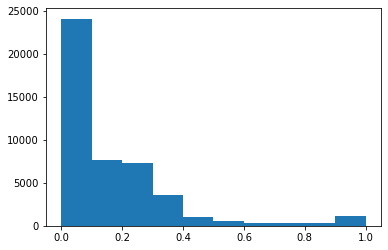

8


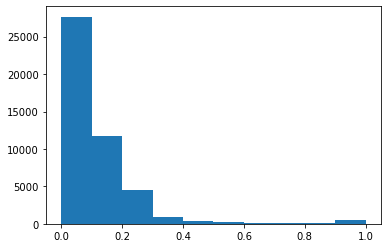

9


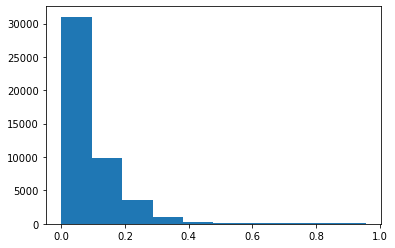

10


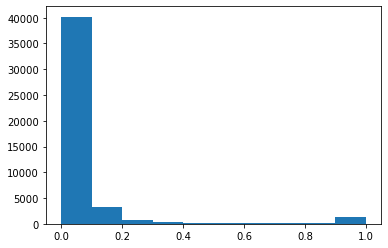

11


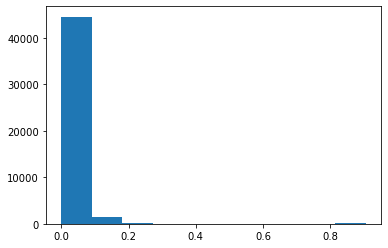

12


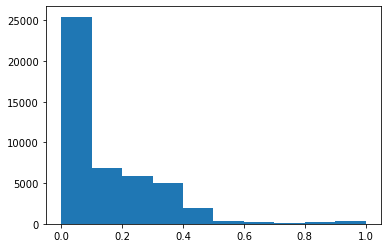

13


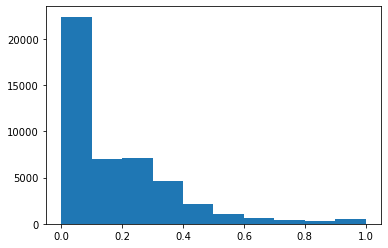

14


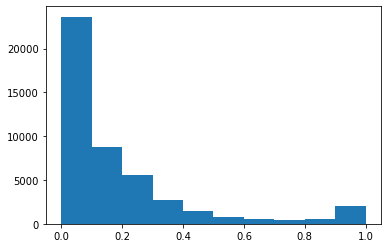

15


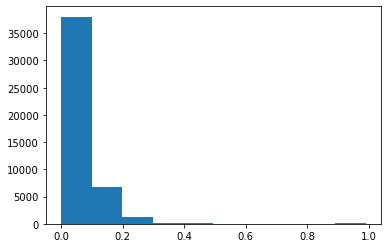

16


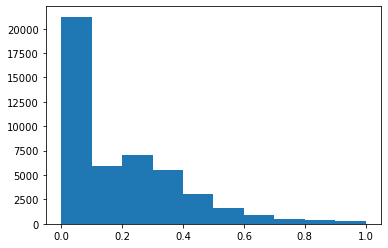

17


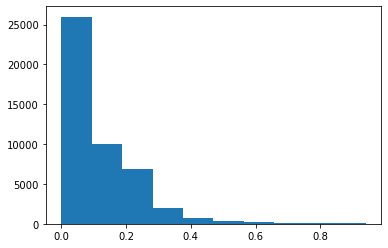

18


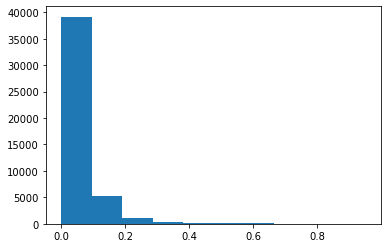

In [117]:
for i in range(19):
    print(i)
    plt.hist(exp15[f'{i}'])
    plt.show()

In [118]:
fold0 = train_all_df[train_all_df['fold']==0].reset_index(drop=True)

In [119]:
fold0 = fold0.iloc[:,:5]

In [120]:
fold0_oof = pd.concat([fold0,exp15],axis=1)

In [122]:
fold0_oof[fold0_oof['11']>0.7]

,saved_ID,saved_label,saved_path,common_ID,fold,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
425,d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0_12,11,Cytosol/d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0_12,d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0,0,0.029189,0.027337,0.010936,0.000596,0.001755,...,0.007493,0.007697,0.866783,0.004487,0.034308,0.023319,7.570693e-06,0.117598,0.002928,0.033492
446,dccab450-bb99-11e8-b2b9-ac1f6b6435d0_6,11,Nucleoli/dccab450-bb99-11e8-b2b9-ac1f6b6435d0_6,dccab450-bb99-11e8-b2b9-ac1f6b6435d0,0,0.021529,0.048289,0.051309,0.007098,0.007532,...,0.024302,0.012090,0.848636,0.036945,0.073858,0.054334,1.649769e-04,0.067401,0.002265,0.033165
1302,b973a4d4-bb9a-11e8-b2b9-ac1f6b6435d0_36,11,Mitochondria/b973a4d4-bb9a-11e8-b2b9-ac1f6b643...,b973a4d4-bb9a-11e8-b2b9-ac1f6b6435d0,0,0.015042,0.010533,0.003032,0.000093,0.000292,...,0.000302,0.000225,0.885045,0.001100,0.002051,0.022906,3.327705e-07,0.019012,0.000096,0.019000
2428,76a43194-bb9c-11e8-b2b9-ac1f6b6435d0_3,11,Nucleoli/76a43194-bb9c-11e8-b2b9-ac1f6b6435d0_3,76a43194-bb9c-11e8-b2b9-ac1f6b6435d0,0,0.009761,0.023074,0.018347,0.000431,0.000972,...,0.000917,0.001660,0.902059,0.002393,0.005744,0.025950,2.339143e-06,0.017746,0.000259,0.028258
2504,84b49e36-bb9c-11e8-b2b9-ac1f6b6435d0_34,11,Centrosome/84b49e36-bb9c-11e8-b2b9-ac1f6b6435d...,84b49e36-bb9c-11e8-b2b9-ac1f6b6435d0,0,0.032033,0.078334,0.048866,0.003762,0.010466,...,0.002876,0.001769,0.846005,0.081020,0.006550,0.021269,1.105103e-04,0.012592,0.002155,0.029230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45572,2f94918a-bbca-11e8-b2bc-ac1f6b6435d0_3,11,Nucleoplasm/2f94918a-bbca-11e8-b2bc-ac1f6b6435...,2f94918a-bbca-11e8-b2bc-ac1f6b6435d0,0,0.192926,0.193129,0.086121,0.018948,0.053887,...,0.019969,0.027218,0.727275,0.033502,0.040596,0.179940,1.124873e-03,0.115506,0.017005,0.242229
45676,3c433f62-bbca-11e8-b2bc-ac1f6b6435d0_4,11,Mitochondria/3c433f62-bbca-11e8-b2bc-ac1f6b643...,3c433f62-bbca-11e8-b2bc-ac1f6b6435d0,0,0.000470,0.001010,0.000227,0.000003,0.000008,...,0.000011,0.000009,0.867199,0.000045,0.000180,0.006438,1.540077e-09,0.001901,0.000004,0.002027
45791,64d6ea28-bbca-11e8-b2bc-ac1f6b6435d0_37,11,Nucleoplasm/64d6ea28-bbca-11e8-b2bc-ac1f6b6435...,64d6ea28-bbca-11e8-b2bc-ac1f6b6435d0,0,0.216438,0.165968,0.191290,0.070210,0.142882,...,0.047133,0.043700,0.714427,0.107744,0.067835,0.088843,4.190706e-03,0.168345,0.047508,0.317438
46202,201c2922-bba0-11e8-b2b9-ac1f6b6435d0_23,11,to_hand_label_11/201c2922-bba0-11e8-b2b9-ac1f6...,201c2922-bba0-11e8-b2b9-ac1f6b6435d0,0,0.074041,0.071965,0.042136,0.004874,0.013635,...,0.021059,0.022690,0.846859,0.024623,0.051403,0.096750,1.587583e-04,0.167677,0.006785,0.091936


In [125]:
pd.read_csv('step2_multi_masked_crop_bgr_256_df.csv')

,saved_ID,saved_label,saved_path
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_0,8|5|0,multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...
1,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_1,8|5|0,multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...
2,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_2,8|5|0,multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...
3,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_3,8|5|0,multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...
4,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_4,8|5|0,multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...
...,...,...,...
230211,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_27,5|0,multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...
230212,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_28,5|0,multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...
230213,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_29,5|0,multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...
230214,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_30,5|0,multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...


# make train_df last

In [159]:
single_handlabel = pd.read_csv('single_handlabel.csv')

In [160]:
single_handlabel_18  = single_handlabel[single_handlabel['saved_label']=='18'].reset_index(drop=True)

In [161]:
single_handlabel_18

,saved_ID,saved_label,saved_path,common_ID,fold,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
0,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_0,18,Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,0,0.779580,0.059570,0.077613,0.027798,0.149207,...,0.015041,0.030813,0.008549,0.073127,0.048421,0.086474,0.010566,0.086455,0.066216,0.138349
1,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_1,18,Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,0,0.500723,0.108508,0.336437,0.084233,0.177412,...,0.034773,0.103846,0.035998,0.139221,0.129451,0.180722,0.049262,0.188157,0.205140,0.273789
2,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_3,18,Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,0,0.910989,0.021374,0.023637,0.013224,0.132103,...,0.005800,0.006936,0.003305,0.018180,0.016059,0.023693,0.001135,0.055111,0.018630,0.018232
3,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_4,18,Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,0,0.843897,0.048918,0.053137,0.027170,0.209887,...,0.006360,0.006686,0.003530,0.037863,0.015128,0.014360,0.004235,0.038005,0.039441,0.030027
4,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_6,18,Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,0,0.838731,0.024590,0.056286,0.020358,0.257539,...,0.003500,0.004348,0.001869,0.027535,0.011124,0.013685,0.003102,0.025452,0.032428,0.020349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,2adbadaa-bbba-11e8-b2ba-ac1f6b6435d0_9,18,to_hand_label_11/2adbadaa-bbba-11e8-b2ba-ac1f6...,2adbadaa-bbba-11e8-b2ba-ac1f6b6435d0,4,0.032821,0.005032,0.049390,0.313577,0.016488,...,0.038243,0.099168,0.030101,0.034270,0.261530,0.203063,0.005370,0.491232,0.010162,0.092639
4103,2adbadaa-bbba-11e8-b2ba-ac1f6b6435d0_11,18,to_hand_label_11/2adbadaa-bbba-11e8-b2ba-ac1f6...,2adbadaa-bbba-11e8-b2ba-ac1f6b6435d0,4,0.056653,0.014546,0.063433,0.148023,0.061986,...,0.097371,0.364274,0.058346,0.050946,0.417374,0.226853,0.011135,0.370525,0.012644,0.196139
4104,2adbadaa-bbba-11e8-b2ba-ac1f6b6435d0_12,18,to_hand_label_11/2adbadaa-bbba-11e8-b2ba-ac1f6...,2adbadaa-bbba-11e8-b2ba-ac1f6b6435d0,4,0.055740,0.018309,0.084373,0.260355,0.038287,...,0.052600,0.244214,0.056010,0.043931,0.371164,0.174946,0.009950,0.335838,0.012309,0.185367
4105,2adbadaa-bbba-11e8-b2ba-ac1f6b6435d0_13,18,to_hand_label_11/2adbadaa-bbba-11e8-b2ba-ac1f6...,2adbadaa-bbba-11e8-b2ba-ac1f6b6435d0,4,0.021838,0.004814,0.048652,0.108982,0.024129,...,0.048168,0.263905,0.028992,0.020997,0.485366,0.108567,0.004341,0.418295,0.004896,0.149318


In [162]:
# saiyou_18 = []
# for x in single_handlabel_18.values:
#     if x[5] > 0.3 :
#         continue
#     if x[-3] > 0.3 :
#         continue
#     saiyou_18.append(x)

In [163]:
single_handlabel[single_handlabel['saved_label']=='15']

,saved_ID,saved_label,saved_path,common_ID,fold,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
546,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_0,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_0,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.250505,0.116841,0.256337,0.236173,0.254613,...,0.174796,6.518784e-02,4.113428e-02,0.305097,0.315534,0.431575,0.190704,0.275460,0.218266,0.200236
547,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_1,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_1,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.227005,0.055595,0.124493,0.098657,0.128426,...,0.145395,5.289529e-02,2.313017e-02,0.363868,0.313241,0.404037,0.201296,0.307833,0.181989,0.100267
548,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_2,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_2,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.239178,0.134599,0.239648,0.261574,0.122575,...,0.122438,2.969828e-02,2.447241e-02,0.354335,0.295199,0.399872,0.235826,0.288734,0.161194,0.206913
549,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_4,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_4,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.108009,0.056446,0.159296,0.160679,0.117632,...,0.214205,1.111412e-02,8.650039e-03,0.412876,0.388259,0.213517,0.431569,0.236781,0.163398,0.134130
550,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_5,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_5,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.009641,0.000903,0.065655,0.023822,0.004036,...,0.007963,3.700000e-06,5.260000e-06,0.301998,0.056153,0.038452,0.807455,0.030259,0.020980,0.028086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218387,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_35,15,Aggresome/d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_35,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0,4,0.205351,0.019580,0.094659,0.023456,0.023947,...,0.162097,3.220437e-03,1.887285e-03,0.278351,0.409392,0.213578,0.234334,0.256962,0.411491,0.020920
218388,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_36,15,Aggresome/d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_36,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0,4,0.184019,0.035623,0.186694,0.069596,0.051771,...,0.171054,3.002260e-03,3.712329e-03,0.303722,0.303487,0.139255,0.224547,0.330373,0.528388,0.027657
218389,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_37,15,Aggresome/d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_37,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0,4,0.345551,0.034081,0.336735,0.082130,0.122009,...,0.103048,8.530495e-02,3.497850e-02,0.226177,0.332564,0.317684,0.120171,0.307700,0.184743,0.054360
224442,56aea646-bbc2-11e8-b2bb-ac1f6b6435d0_20,15,Intermediate/56aea646-bbc2-11e8-b2bb-ac1f6b643...,56aea646-bbc2-11e8-b2bb-ac1f6b6435d0,4,0.015613,0.000009,0.016134,0.000613,0.000239,...,0.000788,2.710000e-08,9.520000e-08,0.076121,0.023463,0.006351,0.901614,0.025382,0.032135,0.007782


In [164]:
single_handlabel_15 = single_handlabel[single_handlabel['saved_label']=='15'].reset_index(drop=True)

In [165]:
saiyou_15 = []
for x in single_handlabel_15.values:
    if x[-4] < 0.5:
        continue
    saiyou_15.append(x)

In [166]:
saiyou_15_df = pd.DataFrame(saiyou_15,columns=single_handlabel_15.columns.to_list()).reset_index(drop=True)

In [167]:
saiyou_15_df

,saved_ID,saved_label,saved_path,common_ID,fold,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
0,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_5,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_5,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.009641,0.000903,0.065655,0.023822,0.004036,...,0.007963,3.700000e-06,5.260000e-06,0.301998,0.056153,0.038452,0.807455,0.030259,0.020980,0.028086
1,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_9,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_9,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.011431,0.000718,0.026496,0.013359,0.004463,...,0.021709,4.890000e-06,7.390000e-06,0.275897,0.120774,0.065812,0.796203,0.071608,0.034375,0.021085
2,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_16,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_16,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.011942,0.001522,0.035045,0.014392,0.015339,...,0.026665,6.470000e-05,6.810000e-05,0.176593,0.139782,0.204505,0.696145,0.124548,0.071778,0.018163
3,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_17,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_17,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.003556,0.000084,0.049850,0.010203,0.001778,...,0.002918,2.150000e-07,5.330000e-07,0.144432,0.033304,0.037299,0.871983,0.029391,0.019292,0.009932
4,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_23,15,Aggresome/f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0_23,f0ac7116-bb99-11e8-b2b9-ac1f6b6435d0,0,0.011092,0.003220,0.087378,0.015943,0.005777,...,0.011538,4.120000e-05,4.800000e-05,0.167782,0.141653,0.365991,0.707285,0.097942,0.038763,0.012607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_19,15,Aggresome/d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_19,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0,4,0.117727,0.001342,0.053161,0.004921,0.002919,...,0.030044,6.830000e-05,6.370000e-05,0.287360,0.305086,0.155227,0.697763,0.113561,0.091058,0.018173
435,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_27,15,Aggresome/d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_27,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0,4,0.038277,0.000137,0.016297,0.001574,0.000244,...,0.008471,8.740000e-08,3.990000e-07,0.229284,0.149128,0.039659,0.892406,0.043137,0.029544,0.030968
436,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_32,15,Aggresome/d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0_32,d85149bc-bbbb-11e8-b2ba-ac1f6b6435d0,4,0.113717,0.007100,0.128992,0.029537,0.007195,...,0.082564,9.676770e-04,8.443150e-04,0.380494,0.329355,0.233283,0.633471,0.199434,0.125419,0.068344
437,56aea646-bbc2-11e8-b2bb-ac1f6b6435d0_20,15,Intermediate/56aea646-bbc2-11e8-b2bb-ac1f6b643...,56aea646-bbc2-11e8-b2bb-ac1f6b6435d0,4,0.015613,0.000009,0.016134,0.000613,0.000239,...,0.000788,2.710000e-08,9.520000e-08,0.076121,0.023463,0.006351,0.901614,0.025382,0.032135,0.007782


In [168]:
saiyou_11_df = single_handlabel[single_handlabel['saved_label']=='11'].reset_index(drop=True)

In [169]:
saiyou_11_df

,saved_ID,saved_label,saved_path,common_ID,fold,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
0,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_8,11,Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_8,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0,0,0.011604,0.000500,0.058493,0.959194,0.007081,...,0.006418,0.000772,0.000418,0.003283,0.018155,0.000533,0.000349,0.006635,0.000208,0.002290
1,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_11,11,Nucleoli/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_11,5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0,0,0.022392,0.004432,0.675899,0.378475,0.029797,...,0.022573,0.004771,0.002052,0.077948,0.112015,0.040564,0.094454,0.041471,0.037388,0.018083
2,d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0_12,11,Cytosol/d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0_12,d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0,0,0.261713,0.037142,0.170530,0.110265,0.134198,...,0.258423,0.101424,0.050600,0.279373,0.460027,0.262746,0.104513,0.452595,0.210749,0.080127
3,dccab450-bb99-11e8-b2b9-ac1f6b6435d0_6,11,Nucleoli/dccab450-bb99-11e8-b2b9-ac1f6b6435d0_6,dccab450-bb99-11e8-b2b9-ac1f6b6435d0,0,0.337478,0.011123,0.175543,0.161985,0.113308,...,0.136088,0.059381,0.046211,0.110405,0.380728,0.164480,0.042929,0.502057,0.059173,0.161640
4,b973a4d4-bb9a-11e8-b2b9-ac1f6b6435d0_36,11,Mitochondria/b973a4d4-bb9a-11e8-b2b9-ac1f6b643...,b973a4d4-bb9a-11e8-b2b9-ac1f6b6435d0,0,0.620857,0.060743,0.131483,0.056369,0.088386,...,0.033219,0.042302,0.026728,0.183268,0.177539,0.382472,0.043189,0.319840,0.049153,0.066104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,19e9765e-bbc3-11e8-b2bc-ac1f6b6435d0_35,11,to_hand_label_11/19e9765e-bbc3-11e8-b2bc-ac1f6...,19e9765e-bbc3-11e8-b2bc-ac1f6b6435d0,4,0.504516,0.010662,0.038418,0.014052,0.059818,...,0.024558,0.455382,0.105145,0.041508,0.154462,0.059756,0.002978,0.503992,0.029426,0.046092
1103,19e9765e-bbc3-11e8-b2bc-ac1f6b6435d0_37,11,to_hand_label_11/19e9765e-bbc3-11e8-b2bc-ac1f6...,19e9765e-bbc3-11e8-b2bc-ac1f6b6435d0,4,0.364383,0.014455,0.050259,0.019153,0.063938,...,0.029150,0.661353,0.098078,0.039724,0.169463,0.080423,0.002236,0.395141,0.020332,0.032294
1104,7b4d2008-bbc8-11e8-b2bc-ac1f6b6435d0_9,11,to_hand_label_11/7b4d2008-bbc8-11e8-b2bc-ac1f6...,7b4d2008-bbc8-11e8-b2bc-ac1f6b6435d0,4,0.180140,0.096304,0.161009,0.362955,0.161510,...,0.039428,0.339283,0.056476,0.077870,0.166635,0.038771,0.010394,0.142423,0.025751,0.052784
1105,7b4d2008-bbc8-11e8-b2bc-ac1f6b6435d0_10,11,to_hand_label_11/7b4d2008-bbc8-11e8-b2bc-ac1f6...,7b4d2008-bbc8-11e8-b2bc-ac1f6b6435d0,4,0.276608,0.079456,0.100684,0.179041,0.105887,...,0.089324,0.297936,0.100900,0.104349,0.354332,0.128205,0.015831,0.417024,0.047710,0.087117


In [170]:
single_handlabel_12 = single_handlabel[single_handlabel['saved_label']=='12'].reset_index(drop=True)

In [171]:
single_handlabel_12

,saved_ID,saved_label,saved_path,common_ID,fold,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
0,7318293e-bb99-11e8-b2b9-ac1f6b6435d0_0,12,Centrosome/7318293e-bb99-11e8-b2b9-ac1f6b6435d0_0,7318293e-bb99-11e8-b2b9-ac1f6b6435d0,0,0.541259,0.394742,0.087796,0.091806,0.081565,...,0.054401,0.012594,0.005971,0.295613,0.134279,0.120767,0.059815,0.083852,0.081956,0.101243
1,7318293e-bb99-11e8-b2b9-ac1f6b6435d0_1,12,Centrosome/7318293e-bb99-11e8-b2b9-ac1f6b6435d0_1,7318293e-bb99-11e8-b2b9-ac1f6b6435d0,0,0.515375,0.148178,0.093114,0.110048,0.075189,...,0.154120,0.035299,0.014811,0.410723,0.241417,0.164629,0.078705,0.173979,0.121083,0.057807
2,7318293e-bb99-11e8-b2b9-ac1f6b6435d0_2,12,Centrosome/7318293e-bb99-11e8-b2b9-ac1f6b6435d0_2,7318293e-bb99-11e8-b2b9-ac1f6b6435d0,0,0.200452,0.049375,0.110077,0.134710,0.038169,...,0.156262,0.013917,0.004416,0.691311,0.171956,0.070288,0.151505,0.128988,0.151047,0.043456
3,7318293e-bb99-11e8-b2b9-ac1f6b6435d0_3,12,Centrosome/7318293e-bb99-11e8-b2b9-ac1f6b6435d0_3,7318293e-bb99-11e8-b2b9-ac1f6b6435d0,0,0.465040,0.304005,0.129655,0.190748,0.069047,...,0.100950,0.035920,0.019033,0.507605,0.160414,0.149745,0.079434,0.170747,0.121431,0.065851
4,7318293e-bb99-11e8-b2b9-ac1f6b6435d0_4,12,Centrosome/7318293e-bb99-11e8-b2b9-ac1f6b6435d0_4,7318293e-bb99-11e8-b2b9-ac1f6b6435d0,0,0.405960,0.048283,0.195812,0.415450,0.110398,...,0.119637,0.034823,0.025994,0.357566,0.141687,0.146780,0.085217,0.146608,0.070101,0.049411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12519,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0_42,12,Centrosome/96f063c2-bbca-11e8-b2bc-ac1f6b6435d...,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0,4,0.244703,0.218710,0.070529,0.063777,0.061167,...,0.196234,0.102563,0.031593,0.337027,0.373294,0.245873,0.103733,0.351751,0.272264,0.080836
12520,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0_43,12,Centrosome/96f063c2-bbca-11e8-b2bc-ac1f6b6435d...,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0,4,0.158504,0.113884,0.137750,0.144601,0.118467,...,0.135770,0.044280,0.024384,0.323839,0.288580,0.358269,0.131907,0.346388,0.270490,0.064806
12521,fb671240-bbbd-11e8-b2ba-ac1f6b6435d0_0,12,to_hand_label_11/fb671240-bbbd-11e8-b2ba-ac1f6...,fb671240-bbbd-11e8-b2ba-ac1f6b6435d0,4,0.049948,0.042973,0.130357,0.083533,0.041036,...,0.074302,0.493811,0.062178,0.103374,0.449779,0.191412,0.017099,0.387494,0.035022,0.046410
12522,fb671240-bbbd-11e8-b2ba-ac1f6b6435d0_2,12,to_hand_label_11/fb671240-bbbd-11e8-b2ba-ac1f6...,fb671240-bbbd-11e8-b2ba-ac1f6b6435d0,4,0.154955,0.069413,0.155110,0.186498,0.090665,...,0.045335,0.713285,0.107803,0.094043,0.205053,0.084757,0.007217,0.175588,0.018872,0.049096


In [172]:
saiyou_12 = []
for x in single_handlabel_12.values:

    if x[-7] < 0.7:

        continue
    saiyou_12.append(x)
        

In [173]:
saiyou_12_df = pd.DataFrame(saiyou_12,columns=single_handlabel_12.columns.to_list()).reset_index(drop=True)

In [174]:
saiyou_12_df

,saved_ID,saved_label,saved_path,common_ID,fold,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
0,7318293e-bb99-11e8-b2b9-ac1f6b6435d0_10,12,Centrosome/7318293e-bb99-11e8-b2b9-ac1f6b6435d...,7318293e-bb99-11e8-b2b9-ac1f6b6435d0,0,0.182173,0.030692,0.070471,0.220191,0.020718,...,0.070910,0.002150,9.610240e-04,0.735834,0.064869,0.029085,0.095829,0.056669,0.044340,0.019645
1,7318293e-bb99-11e8-b2b9-ac1f6b6435d0_21,12,Centrosome/7318293e-bb99-11e8-b2b9-ac1f6b6435d...,7318293e-bb99-11e8-b2b9-ac1f6b6435d0,0,0.151765,0.060513,0.058883,0.080522,0.024907,...,0.053878,0.004874,1.350097e-03,0.741783,0.069491,0.062672,0.174078,0.068013,0.089290,0.034960
2,7318293e-bb99-11e8-b2b9-ac1f6b6435d0_22,12,Centrosome/7318293e-bb99-11e8-b2b9-ac1f6b6435d...,7318293e-bb99-11e8-b2b9-ac1f6b6435d0,0,0.207741,0.029753,0.045873,0.173480,0.035185,...,0.061810,0.008900,1.723126e-03,0.762634,0.034557,0.022560,0.052762,0.035091,0.026492,0.014073
3,e3195c44-bb99-11e8-b2b9-ac1f6b6435d0_4,12,Nucleoplasm/e3195c44-bb99-11e8-b2b9-ac1f6b6435...,e3195c44-bb99-11e8-b2b9-ac1f6b6435d0,0,0.322851,0.016486,0.001339,0.005151,0.002407,...,0.052374,0.000305,2.720000e-05,0.791447,0.034057,0.009763,0.018236,0.015619,0.009313,0.001689
4,f640b4d4-bb99-11e8-b2b9-ac1f6b6435d0_4,12,Centrosome/f640b4d4-bb99-11e8-b2b9-ac1f6b6435d0_4,f640b4d4-bb99-11e8-b2b9-ac1f6b6435d0,0,0.230762,0.009790,0.001345,0.002188,0.000622,...,0.044485,0.000733,3.350000e-05,0.725649,0.141435,0.029549,0.026592,0.044692,0.010502,0.003766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,8d764d84-bbca-11e8-b2bc-ac1f6b6435d0_16,12,Centrosome/8d764d84-bbca-11e8-b2bc-ac1f6b6435d...,8d764d84-bbca-11e8-b2bc-ac1f6b6435d0,4,0.000858,0.000075,0.000025,0.000115,0.000001,...,0.000948,0.000019,2.050000e-08,0.980660,0.000281,0.000059,0.002985,0.003214,0.001538,0.000003
2505,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0_8,12,Centrosome/96f063c2-bbca-11e8-b2bc-ac1f6b6435d0_8,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0,4,0.025710,0.009228,0.002764,0.005675,0.000650,...,0.041303,0.008168,1.777430e-04,0.895551,0.024585,0.008654,0.042551,0.076421,0.048930,0.001365
2506,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0_20,12,Centrosome/96f063c2-bbca-11e8-b2bc-ac1f6b6435d...,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0,4,0.038131,0.002465,0.001217,0.004127,0.000342,...,0.020689,0.001230,1.680000e-05,0.922552,0.009530,0.003657,0.021692,0.020530,0.015429,0.000183
2507,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0_32,12,Centrosome/96f063c2-bbca-11e8-b2bc-ac1f6b6435d...,96f063c2-bbca-11e8-b2bc-ac1f6b6435d0,4,0.057251,0.009270,0.006357,0.011814,0.001667,...,0.034218,0.003739,1.830530e-04,0.887318,0.018176,0.017837,0.065260,0.061753,0.050285,0.001527


In [175]:
single_handlabel_17 = single_handlabel[single_handlabel['saved_label']=='17'].reset_index(drop=True)

In [176]:
single_handlabel_17

,saved_ID,saved_label,saved_path,common_ID,fold,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
0,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_0,17,Vesicles/f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_0,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0,0,0.175388,0.143742,0.123160,0.197197,0.121283,...,0.156994,0.045085,0.028243,0.443476,0.221418,0.245039,0.248604,0.296617,0.214113,0.149635
1,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_1,17,Vesicles/f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_1,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0,0,0.256126,0.107661,0.201489,0.202385,0.150871,...,0.243127,0.124840,0.044548,0.398137,0.276600,0.198624,0.128731,0.259090,0.245599,0.192389
2,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_2,17,Vesicles/f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_2,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0,0,0.286257,0.077421,0.244773,0.191756,0.240333,...,0.135626,0.043855,0.027441,0.368226,0.212096,0.336962,0.204824,0.230982,0.252117,0.104268
3,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_3,17,Vesicles/f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_3,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0,0,0.061834,0.025474,0.083373,0.075701,0.067134,...,0.058696,0.000711,0.001151,0.374804,0.100856,0.126037,0.524557,0.221167,0.359480,0.061122
4,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_4,17,Vesicles/f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_4,f2b11656-bb99-11e8-b2b9-ac1f6b6435d0,0,0.142263,0.077287,0.112494,0.093953,0.078130,...,0.141758,0.040822,0.014729,0.550584,0.164367,0.193740,0.149659,0.303929,0.408737,0.049080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5399,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_30,17,Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_30,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0,4,0.269237,0.023169,0.045318,0.013431,0.097598,...,0.121823,0.016399,0.006055,0.163283,0.281200,0.132353,0.068516,0.310749,0.533389,0.018621
5400,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_31,17,Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_31,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0,4,0.296227,0.077089,0.238047,0.188755,0.301490,...,0.131429,0.017531,0.020950,0.308535,0.192474,0.204835,0.232456,0.226962,0.322850,0.235300
5401,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_32,17,Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_32,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0,4,0.281267,0.112422,0.268818,0.247113,0.217042,...,0.151235,0.018842,0.021742,0.296052,0.237312,0.220271,0.236222,0.228544,0.339201,0.182227
5402,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_33,17,Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_33,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0,4,0.214706,0.042616,0.058753,0.019514,0.092586,...,0.159694,0.011908,0.004717,0.284798,0.189844,0.109999,0.081308,0.317370,0.628979,0.016885


In [177]:
saiyou_17 = []
for x in single_handlabel_17.values:

    if x[-2] < 0.7:

        continue
    saiyou_17.append(x)
        

In [178]:
saiyou_17_df = pd.DataFrame(saiyou_17,columns=single_handlabel_12.columns.to_list()).reset_index(drop=True)

In [179]:
saiyou_17_df

,saved_ID,saved_label,saved_path,common_ID,fold,0,1,2,3,4,...,9,10,11,12,13,14,15,16,17,18
0,6049060a-bba0-11e8-b2b9-ac1f6b6435d0_5,17,Vesicles/6049060a-bba0-11e8-b2b9-ac1f6b6435d0_5,6049060a-bba0-11e8-b2b9-ac1f6b6435d0,0,0.266781,0.127627,0.083945,0.036402,0.151477,...,0.164936,0.004458,0.001983,0.101706,0.123287,0.234632,0.019502,0.159540,0.813463,0.015839
1,6049060a-bba0-11e8-b2b9-ac1f6b6435d0_10,17,Vesicles/6049060a-bba0-11e8-b2b9-ac1f6b6435d0_10,6049060a-bba0-11e8-b2b9-ac1f6b6435d0,0,0.223412,0.071649,0.051774,0.020374,0.120928,...,0.192426,0.015903,0.002834,0.124472,0.135436,0.323789,0.014704,0.177067,0.766026,0.013991
2,6049060a-bba0-11e8-b2b9-ac1f6b6435d0_11,17,Vesicles/6049060a-bba0-11e8-b2b9-ac1f6b6435d0_11,6049060a-bba0-11e8-b2b9-ac1f6b6435d0,0,0.359986,0.153831,0.103653,0.028429,0.100469,...,0.070649,0.002707,0.001379,0.092730,0.091575,0.146093,0.019494,0.132545,0.771879,0.019840
3,6049060a-bba0-11e8-b2b9-ac1f6b6435d0_12,17,Vesicles/6049060a-bba0-11e8-b2b9-ac1f6b6435d0_12,6049060a-bba0-11e8-b2b9-ac1f6b6435d0,0,0.235864,0.070291,0.063885,0.015109,0.054940,...,0.079783,0.000770,0.000371,0.054871,0.094028,0.125849,0.010316,0.144984,0.860992,0.007039
4,6049060a-bba0-11e8-b2b9-ac1f6b6435d0_15,17,Vesicles/6049060a-bba0-11e8-b2b9-ac1f6b6435d0_15,6049060a-bba0-11e8-b2b9-ac1f6b6435d0,0,0.264341,0.079383,0.075398,0.043449,0.142005,...,0.220381,0.013038,0.004183,0.119219,0.155984,0.300240,0.015216,0.212465,0.768198,0.014079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,5ecbc5a0-bbc9-11e8-b2bc-ac1f6b6435d0_10,17,Vesicles/5ecbc5a0-bbc9-11e8-b2bc-ac1f6b6435d0_10,5ecbc5a0-bbc9-11e8-b2bc-ac1f6b6435d0,4,0.012863,0.002573,0.003943,0.000328,0.009121,...,0.036732,0.000737,0.000060,0.015354,0.042197,0.053768,0.002731,0.273102,0.889704,0.000158
555,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_14,17,Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_14,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0,4,0.102483,0.011158,0.039064,0.008088,0.045679,...,0.110249,0.000918,0.000531,0.041457,0.096321,0.030952,0.011336,0.258334,0.849891,0.001592
556,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_17,17,Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_17,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0,4,0.130330,0.035369,0.070672,0.016259,0.080836,...,0.115221,0.003124,0.001872,0.117226,0.121546,0.086091,0.032663,0.297095,0.819868,0.007018
557,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_21,17,Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_21,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0,4,0.178031,0.031888,0.088251,0.025806,0.083754,...,0.088232,0.003726,0.002979,0.141555,0.153981,0.084116,0.065589,0.314530,0.747975,0.010907


In [180]:
use_single_label_df = pd.concat([single_handlabel_18,saiyou_15_df])

In [181]:
use_single_label_df = pd.concat([use_single_label_df,saiyou_11_df])

In [182]:
use_single_label_df = pd.concat([use_single_label_df,saiyou_12_df])

In [183]:
use_single_label_df = pd.concat([use_single_label_df,saiyou_17_df])

In [184]:
use_single_label_df = use_single_label_df.reset_index(drop=True)

In [185]:
def return_list(df):
    return [int(df)]

In [186]:
use_single_label_df['saved_label'] = use_single_label_df.saved_label.map(return_list)

In [187]:
use_single_label_df = use_single_label_df.iloc[:,:4]

In [188]:
use_single_label_df

,saved_ID,saved_label,saved_path,common_ID
0,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_0,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0
1,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_1,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0
2,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_3,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0
3,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_4,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0
4,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_6,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0
...,...,...,...,...
8716,5ecbc5a0-bbc9-11e8-b2bc-ac1f6b6435d0_10,[17],Vesicles/5ecbc5a0-bbc9-11e8-b2bc-ac1f6b6435d0_10,5ecbc5a0-bbc9-11e8-b2bc-ac1f6b6435d0
8717,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_14,[17],Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_14,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0
8718,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_17,[17],Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_17,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0
8719,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_21,[17],Vesicles/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_21,67941ab0-bbca-11e8-b2bc-ac1f6b6435d0


In [189]:
# use_single_label_df.to_csv('use_single_label_df.csv',index=False)

In [190]:
#######################################################

In [21]:
# only_multi_train_df = pd.read_csv('only_multi_train_df.csv')#これをhandで修正中！！！
only_multi_train_df = pd.read_csv('multi_handlabel.csv')#これをhandで修正中！！！


In [17]:
only_multi_train_df

NameError: name 'only_multi_train_df' is not defined

In [48]:
def concat_label(cels_ids):
    cels_ids = str(cels_ids)
    cels_ids = eval(cels_ids)
    len_cels_ids = len(cels_ids)
    len_cels_ids_list = []
    for x in range(len_cels_ids):
        len_cels_ids_list.append(cels_ids[x].split(','))
#     print(len_cels_ids_list)
        
#     cels_ids = cels_ids.split(',')#cels_ids[0].split(',')
    labels = np.zeros(19, dtype="f")
    labels = []
    for i in len_cels_ids_list:
        i = i[0]
        i = int(i)
        labels.append(i)
#         labels[i] = 1
    return labels
        

def split_label(df):
    df = df.split('|')
    return df

def split_common_id(df):
    common_path = df.split('_')[0] + '_' + df.split('_')[1] + '_' +  df.split('_')[2]
    return common_path 

In [54]:
only_multi_train_df = only_multi_train_df[only_multi_train_df['saved_label']!='100'].reset_index(drop=True)

In [56]:
only_multi_train_df['saved_label'] = only_multi_train_df.saved_label.map(concat_label)

In [59]:
only_multi_train_df = only_multi_train_df.iloc[:,:4]

In [60]:
only_multi_train_df

,saved_ID,saved_label,saved_path,common_ID
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_0,"[8, 5, 0]",multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0
1,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_1,"[8, 5, 0]",multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0
2,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_2,"[8, 5, 0, 14]",multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0
3,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_3,"[8, 5, 0]",multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0
4,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0_4,"[8, 5, 0]",multi_masked_crop_bgr_256/5c27f04c-bb99-11e8-b...,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0
...,...,...,...,...
227985,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_27,"[5, 0]",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0
227986,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_28,"[5, 0, 4]",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0
227987,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_29,"[5, 0]",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0
227988,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_30,"[5, 0]",multi_masked_crop_bgr_256/dea19dc6-bbca-11e8-b...,dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0


In [61]:
#######################################################

In [62]:
masked_publichpa_crop_bgr_256_df = pd.read_csv('masked_publichpa_crop_bgr_256_df.csv')

In [63]:
masked_publichpa_crop_bgr_256_df

,saved_ID,saved_label,saved_path
0,1231_G1_1_1,0|13,masked_publichpa_crop_bgr_256/1231_G1_1_1
1,1231_G1_1_2,0|13,masked_publichpa_crop_bgr_256/1231_G1_1_2
2,1231_G1_1_3,0|13,masked_publichpa_crop_bgr_256/1231_G1_1_3
3,1231_G1_1_4,0|13,masked_publichpa_crop_bgr_256/1231_G1_1_4
4,1231_G1_1_5,0|13,masked_publichpa_crop_bgr_256/1231_G1_1_5
...,...,...,...
425645,408_D5_2_16,0|12|16,masked_publichpa_crop_bgr_256/408_D5_2_16
425646,408_D5_2_17,0|12|16,masked_publichpa_crop_bgr_256/408_D5_2_17
425647,408_D5_2_18,0|12|16,masked_publichpa_crop_bgr_256/408_D5_2_18
425648,408_D5_2_19,0|12|16,masked_publichpa_crop_bgr_256/408_D5_2_19


In [64]:
def concat_label(cels_ids):
    cels_ids = str(cels_ids)
    cels_ids = eval(cels_ids)
    len_cels_ids = len(cels_ids)
    len_cels_ids_list = []
    for x in range(len_cels_ids):
        len_cels_ids_list.append(cels_ids[x].split(','))
#     print(len_cels_ids_list)
        
#     cels_ids = cels_ids.split(',')#cels_ids[0].split(',')
    labels = np.zeros(19, dtype="f")
    labels = []
    for i in len_cels_ids_list:
        i = i[0]
        i = int(i)
        labels.append(i)
#         labels[i] = 1
    return labels
        

def split_label(df):
    df = df.split('|')
    return df

def split_common_id(df):
    common_path = df.split('_')[0] + '_' + df.split('_')[1] + '_' +  df.split('_')[2]
    return common_path 

In [65]:
masked_publichpa_crop_bgr_256_df['saved_label'] = masked_publichpa_crop_bgr_256_df.saved_label.map(split_label)

In [66]:
masked_publichpa_crop_bgr_256_df['saved_label'] = masked_publichpa_crop_bgr_256_df.saved_label.map(concat_label)

In [67]:
masked_publichpa_crop_bgr_256_df['common_ID'] = masked_publichpa_crop_bgr_256_df.saved_ID.map(split_common_id)

In [68]:
masked_publichpa_crop_bgr_256_df

,saved_ID,saved_label,saved_path,common_ID
0,1231_G1_1_1,"[0, 13]",masked_publichpa_crop_bgr_256/1231_G1_1_1,1231_G1_1
1,1231_G1_1_2,"[0, 13]",masked_publichpa_crop_bgr_256/1231_G1_1_2,1231_G1_1
2,1231_G1_1_3,"[0, 13]",masked_publichpa_crop_bgr_256/1231_G1_1_3,1231_G1_1
3,1231_G1_1_4,"[0, 13]",masked_publichpa_crop_bgr_256/1231_G1_1_4,1231_G1_1
4,1231_G1_1_5,"[0, 13]",masked_publichpa_crop_bgr_256/1231_G1_1_5,1231_G1_1
...,...,...,...,...
425645,408_D5_2_16,"[0, 12, 16]",masked_publichpa_crop_bgr_256/408_D5_2_16,408_D5_2
425646,408_D5_2_17,"[0, 12, 16]",masked_publichpa_crop_bgr_256/408_D5_2_17,408_D5_2
425647,408_D5_2_18,"[0, 12, 16]",masked_publichpa_crop_bgr_256/408_D5_2_18,408_D5_2
425648,408_D5_2_19,"[0, 12, 16]",masked_publichpa_crop_bgr_256/408_D5_2_19,408_D5_2


In [191]:
#merge
last_train_df = pd.concat([use_single_label_df,only_multi_train_df])

In [192]:
last_train_df = pd.concat([last_train_df,masked_publichpa_crop_bgr_256_df])

In [193]:
last_train_df = last_train_df.reset_index(drop=True)

In [194]:
# import numpy as np
# from sklearn.model_selection import GroupKFold
# X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
# y = np.array([1, 2, 3, 4])
# groups = np.array([0, 0, 2, 2])
# group_kfold = GroupKFold(n_splits=5)
# # group_kfold.get_n_splits(X, y, groupprint(group_kfold))



# for train_index, test_index in group_kfold.split(X, y, groups):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     print(X_train, X_test, y_train, y_test)

In [195]:
import numpy as np
from sklearn.model_selection import GroupKFold
X = last_train_df.saved_ID.values
y = last_train_df.saved_label.values
groups = last_train_df.common_ID.values
group_kfold = GroupKFold(n_splits=5)
# group_kfold.get_n_splits(X, y, groupprint(group_kfold))


last_train_df['fold'] = np.nan

for i,(train_index, test_index) in enumerate (group_kfold.split(X, y, groups)):
    last_train_df.iloc[test_index, -1] = i
    
last_train_df['fold'] = last_train_df['fold'].astype('int')

#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     print(X_train, X_test, y_train, y_test)

In [196]:
last_train_df[last_train_df['fold']==0]

,saved_ID,saved_label,saved_path,common_ID,fold
13,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_0,[18],Centrosome/15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_0,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0,0
14,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_1,[18],Centrosome/15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_1,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0,0
15,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_2,[18],Centrosome/15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_2,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0,0
16,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_3,[18],Centrosome/15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_3,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0,0
17,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_4,[18],Centrosome/15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0_4,15c7c81a-bb9a-11e8-b2b9-ac1f6b6435d0,0
...,...,...,...,...,...
662317,125_C12_1_8,"[0, 16]",masked_publichpa_crop_bgr_256/125_C12_1_8,125_C12_1,0
662318,125_C12_1_9,"[0, 16]",masked_publichpa_crop_bgr_256/125_C12_1_9,125_C12_1,0
662319,125_C12_1_10,"[0, 16]",masked_publichpa_crop_bgr_256/125_C12_1_10,125_C12_1,0
662320,125_C12_1_11,"[0, 16]",masked_publichpa_crop_bgr_256/125_C12_1_11,125_C12_1,0


In [197]:
# import numpy as np
# from sklearn.model_selection import GroupKFold
# #make group k_fold
# id_list = last_train_df.common_ID.value_counts().index

# FOLDS = 5
# for k in range(len(id_list)):
#     last_train_df.loc[last_train_df.common_ID==id_list[k],'fold'] = k%FOLDS

In [198]:
last_train_df

,saved_ID,saved_label,saved_path,common_ID,fold
0,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_0,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,4
1,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_1,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,4
2,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_3,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,4
3,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_4,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,4
4,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_6,[18],Nucleoplasm/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435...,8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0,4
...,...,...,...,...,...
662356,408_D5_2_16,"[0, 12, 16]",masked_publichpa_crop_bgr_256/408_D5_2_16,408_D5_2,4
662357,408_D5_2_17,"[0, 12, 16]",masked_publichpa_crop_bgr_256/408_D5_2_17,408_D5_2,4
662358,408_D5_2_18,"[0, 12, 16]",masked_publichpa_crop_bgr_256/408_D5_2_18,408_D5_2,4
662359,408_D5_2_19,"[0, 12, 16]",masked_publichpa_crop_bgr_256/408_D5_2_19,408_D5_2,4


In [201]:
last_train_df['saved_label'][0][0]

18

In [202]:
last_train_df['saved_label'][662360][0]

0

In [216]:
species_id_count = []
for lis in last_train_df[last_train_df['fold']==4]['saved_label']:
   
    for x in lis:
        species_id_count.append(x)

In [217]:
species_id_all_df = pd.DataFrame(species_id_count)

In [206]:
species_id_all_df.value_counts()

0     85743
16    63947
13    26946
17    19062
2     18249
7     13305
5     10799
14     9427
12     9193
3      6458
4      5848
1      5668
9      5000
10     3199
6      2899
8      2470
15     1028
11      950
18      790
dtype: int64

In [209]:
species_id_all_df.value_counts()

0     85237
16    62654
13    27848
2     17934
17    17568
7     14012
5     10685
12    10185
14     9804
3      6621
1      5775
4      5758
9      5036
6      3565
10     2876
8      2232
15     1428
11     1291
18      922
dtype: int64

In [212]:
species_id_all_df.value_counts()

0     85309
16    63261
13    26628
2     17990
17    17176
7     14310
5     10383
14    10043
12     8787
1      6617
4      6442
3      6016
9      4792
6      3778
10     2778
8      2487
18     1185
15     1015
11      945
dtype: int64

In [215]:
species_id_all_df.value_counts()

0     85724
16    61060
13    27505
2     17933
17    17527
7     14235
5     11240
12    10043
14     9829
3      6551
1      6000
4      5893
9      4250
10     3417
8      3256
6      3157
11     1168
15     1059
18      936
dtype: int64

In [218]:
species_id_all_df.value_counts()

0     84383
16    63281
13    28760
17    18119
2     17117
7     12822
14    10562
5     10127
12     9915
4      6402
1      6286
3      5741
9      5481
6      3537
10     3061
8      2569
15     1120
11     1119
18      849
dtype: int64

In [220]:
# last_train_df.to_csv('Last_train_df_crop_step1.csv',index=False)

# mean std 

In [74]:
# import albumentations as A
# import numpy as np, pandas as pd
# import matplotlib.pyplot as plt

In [75]:
# class LeafData(Dataset):
    
#     def __init__(self, 
#                  data, 
#                  directory, 
#                  transform = None):
#         self.data      = data
#         self.directory = directory
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
        
#         # import
#         path  = os.path.join(self.directory, self.data.iloc[idx]['saved_path'])
#         image = cv2.imread(f'{path}.png')
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         if image.max() > 255:#if uint16 
# #                 print('======================!!!!',retnrn_img.max())
#             image = cv2.convertScaleAbs(image, alpha=(255.0/65535.0))#uint8
        
            
#         # augmentations
#         if self.transform is not None:
#             image = self.transform(image = image)['image']
        
#         # output
#         return image

In [76]:
# image_size = 256

# augs = A.Compose([A.Resize(height = image_size, 
#                            width  = image_size),
#                   A.Normalize(mean = (0, 0, 0),#step1,/255 step2, -mean step3, /std    つまり/255しかしていない #max()=>1 min()=>0
#                               std  = (1, 1, 1)),
#                   ToTensorV2()])

In [79]:
# # dataset
# batch_size = 32
# num_workers = 12

# sample_dataset = LeafData(data      = train_all_df, 
#                           directory = '/home/syuonez/masked_crop_bgr_256/',
#                           transform = augs)

# # data loader
# sample_loader = DataLoader(sample_dataset, 
#                            batch_size  = batch_size, 
#                            shuffle     = False, 
#                            num_workers = num_workers,
#                            pin_memory  = True)

# # display images
# # for batch_idx, (inputs, labels) in enumerate(sample_loader):
# #     fig = plt.figure(figsize = (14, 7))
# #     for i in range(8):
# #         ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
# #         plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
# #     break

In [80]:
# ####### COMPUTE MEAN / STD

# # placeholders
# psum   = torch.tensor([0.0, 0.0, 0.0])
# psumsq = torch.tensor([0.0, 0.0, 0.0])

# # loop through images
# for batch_idx, inputs in tqdm(enumerate(sample_loader), total = len(sample_loader)):
#     psum   += inputs.sum(axis        = [0, 2, 3])
#     psumsq += (inputs ** 2).sum(axis = [0, 2, 3])

    

100%|██████████| 20699/20699 [08:36<00:00, 40.08it/s]


In [81]:
# ####### FINAL CALCULATIONS

# # pixel count
# count = len(train_all_df) * image_size * image_size #len(masked_crop_bgr_256_df_drop_img)

# # mean and std
# total_mean = psum / count
# total_var  = (psumsq / count) - (total_mean ** 2)
# total_std  = torch.sqrt(total_var)

# # output
# print('mean: '  + str(total_mean))
# print('std:  '  + str(total_std))


mean: tensor([0.0680, 0.0583, 0.0566])
std:  tensor([0.1464, 0.1249, 0.1612])
